In [56]:
import h5py
import numpy as np

from e2c_train import create_e2c

from keras import backend as K
from keras.layers import Input
from keras.models import Model

import matplotlib.pyplot as plt
plt.set_cmap('jet')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# GPU memory management
import tensorflow as tf

<Figure size 432x288 with 0 Axes>

In [57]:
# tf.session specification
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

In [58]:
# data_dir = '/data/cees/zjin/lstm_rom/datasets/9W_BHP/'
# data_dir = '/data/cees/zjin/lstm_rom/datasets/9W_BHP_RATE/'
# data_dir = '/data/cees/zjin/lstm_rom/datasets/9W_MS_BHP_RATE/'
# data_dir = '/data3/Astro/personal/zjin/datasets/9W_MS_BHP_RATE_GAU/'
data_dir = '/data3/Astro/personal/zjin/datasets/7W_CHA/'

output_dir = '/data3/Astro/lstm_rom/e2c_larry/saved_models/' # load model data

# case_name = '9w_ms_bhp_rate'
case_name = '7w_cha'

# target_suffix = '_fix_wl_rel_2'
target_suffix = '_fix_wl_rel_1' # the dataset being evaluated here

# case_suffix = '_fix_wl_rel_2'
case_suffix = '_fix_wl_rel_1'

train_suffix = '_with_p'

# model_suffix = '_flux_loss'
model_suffix = '_ae_no_l2_ep_10'

num_t = 20
run_eval = 100
num_eval = num_t * run_eval
# dt = 200 // num_t
dt = 100

eval_file = case_name + '_e2c_eval' + target_suffix + train_suffix + '_n%d_dt%dday_nt%d_nrun%d.mat'%(num_eval, dt, num_t, run_eval)

state_file = case_name + '_train_n_400_full'
ctrl_file = case_name + '_norm_bhps_n_400'

state_data = state_file + target_suffix + '.mat'
ctrl_data = ctrl_file + target_suffix + '.mat'

## Load E2C model

In [59]:
latent_dim, u_dim = 50, 7*2
input_shape = (60, 60, 2) # change from _with_p to _no_p
encoder, decoder, transition = create_e2c(latent_dim, u_dim, input_shape)

num_train, latent_dim, learning_rate, epoch = 6000, 50, 1e-4, 10

In [60]:
encoder.load_weights(output_dir + 'e2c_encoder_dt_'+case_name+case_suffix+train_suffix+model_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))
decoder.load_weights(output_dir + 'e2c_decoder_dt_'+case_name+case_suffix+train_suffix+model_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))
transition.load_weights(output_dir + 'e2c_transition_dt_'+case_name+case_suffix+train_suffix+model_suffix+'_nt%d_l%d_lr%.0e_ep%d.h5' % (num_train, latent_dim, learning_rate, epoch))

## One step prediction

In [61]:
hf_r = h5py.File(data_dir + eval_file, 'r')
state_t_eval = np.array(hf_r.get('state_t'))
state_t1_eval = np.array(hf_r.get('state_t1'))
# print(list(hf_r.keys()))
# state_t_eval = np.array(hf_r.get('sat_t'))
# state_t1_eval = np.array(hf_r.get('sat_t1'))
bhp_eval = np.array(hf_r.get('bhp'))
dt_eval = np.array(hf_r.get('dt'))
hf_r.close()

In [62]:
num_eval = 20 # pick 20 out of 2200 evals
state_t_eval = state_t_eval[:num_eval, ...]
state_t1_eval = state_t1_eval[:num_eval, ...]
bhp_eval = bhp_eval[:num_eval, ...]

In [63]:
print(state_t_eval.shape)
print(state_t1_eval.shape)
print(bhp_eval[:,:5].min().min())
print(bhp_eval[:,:5].max().max())

print(state_t_eval.shape)

(20, 60, 60, 2)
(20, 60, 60, 2)
0.11498278349336552
0.9148943128800923
(20, 60, 60, 2)


In [64]:
xt = Input(shape=input_shape)
xt1 = Input(shape=input_shape)
ut = Input(shape=(u_dim, ))
dt = Input(shape=(1,))

In [65]:
zt = encoder(xt)
xt_rec = decoder(zt)

zt1_pred = transition([zt, ut, dt])
xt1_pred = decoder(zt1_pred)

e2c_model = Model([xt, ut, dt], [xt_rec, xt1_pred])

In [66]:
[state_t_rec, state_t1_pred] = e2c_model.predict([state_t_eval, bhp_eval, dt_eval])

In [67]:
print(state_t_rec.shape)
print(state_t1_pred.shape)

(20, 60, 60, 2)
(20, 60, 60, 2)


In [68]:
print(state_t_eval[:,:,:,0].max())
print(state_t_eval[:,:,:,0].min())

print(state_t_eval[:,:,:,1].max())
print(state_t_eval[:,:,:,1].min())

0.7037495857584125
0.12285965344445751
0.57320408766767
0.24219209421652263


In [69]:
s_max = 1
s_min = 0
s_diff = s_max - s_min

state_t_eval_plot = state_t_eval * s_diff + s_min
state_t_rec_plot = state_t_rec * s_diff + s_min
state_t1_eval_plot = state_t1_eval * s_diff + s_min
state_t1_pred_plot = state_t1_pred * s_diff + s_min

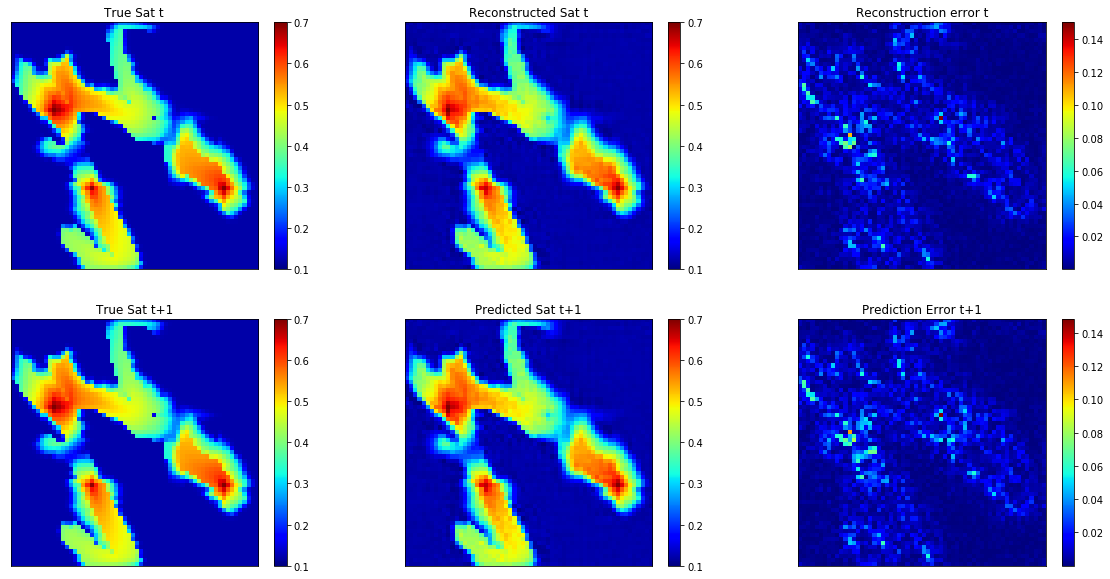

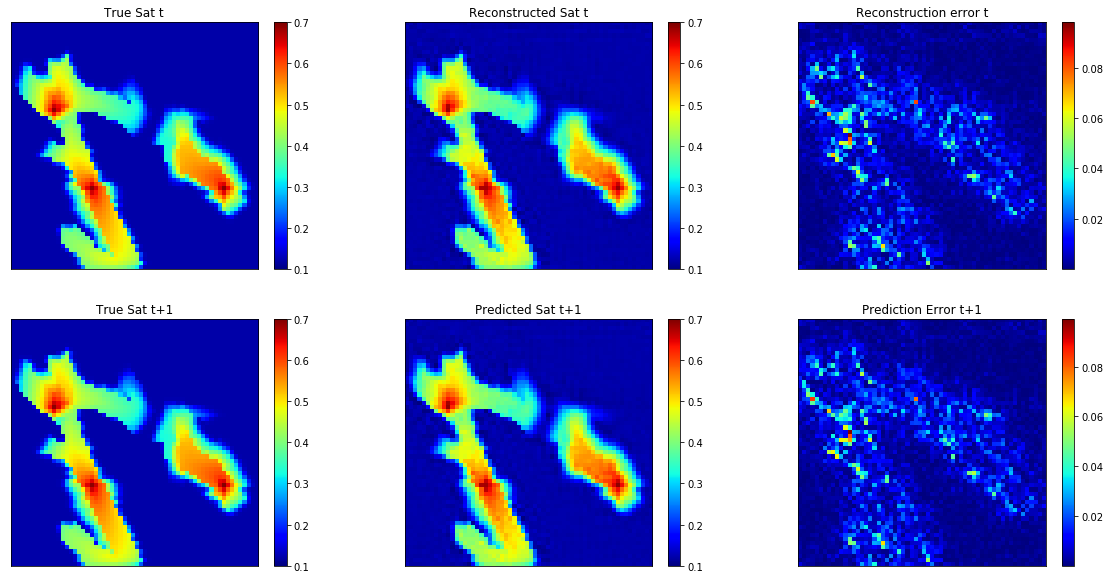

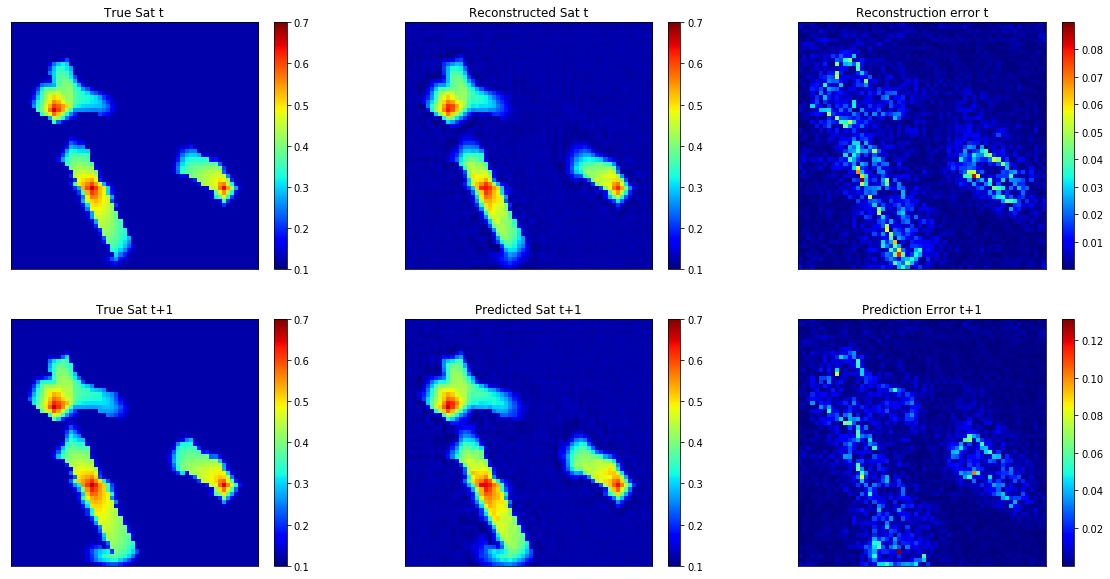

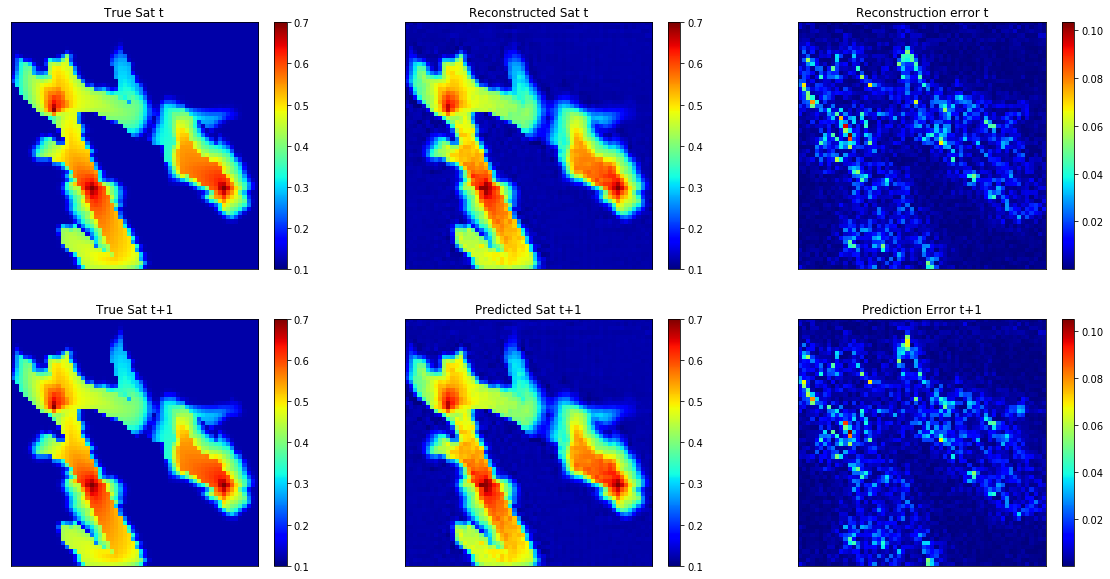

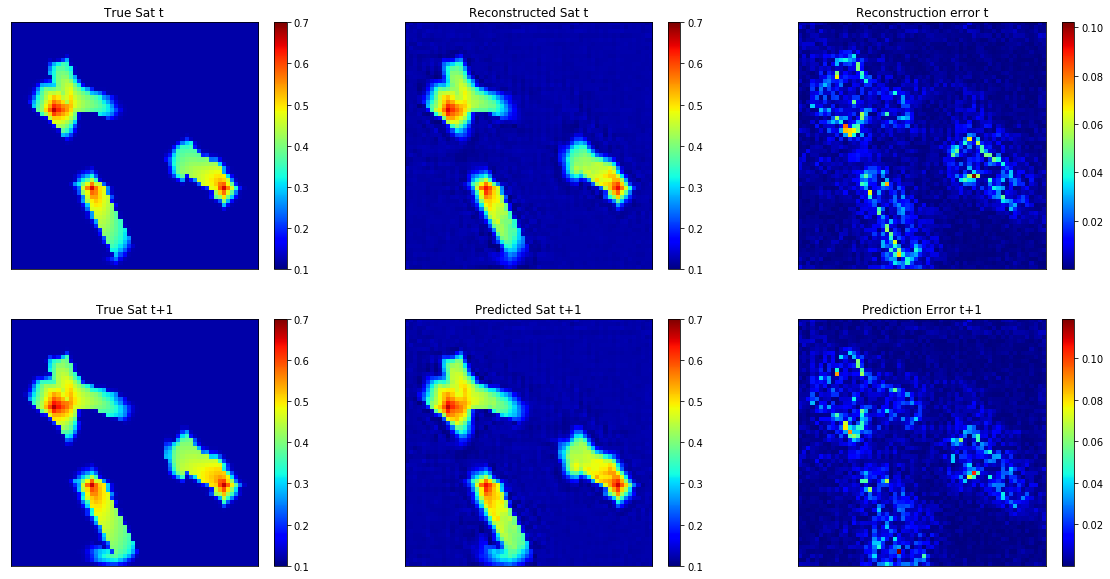

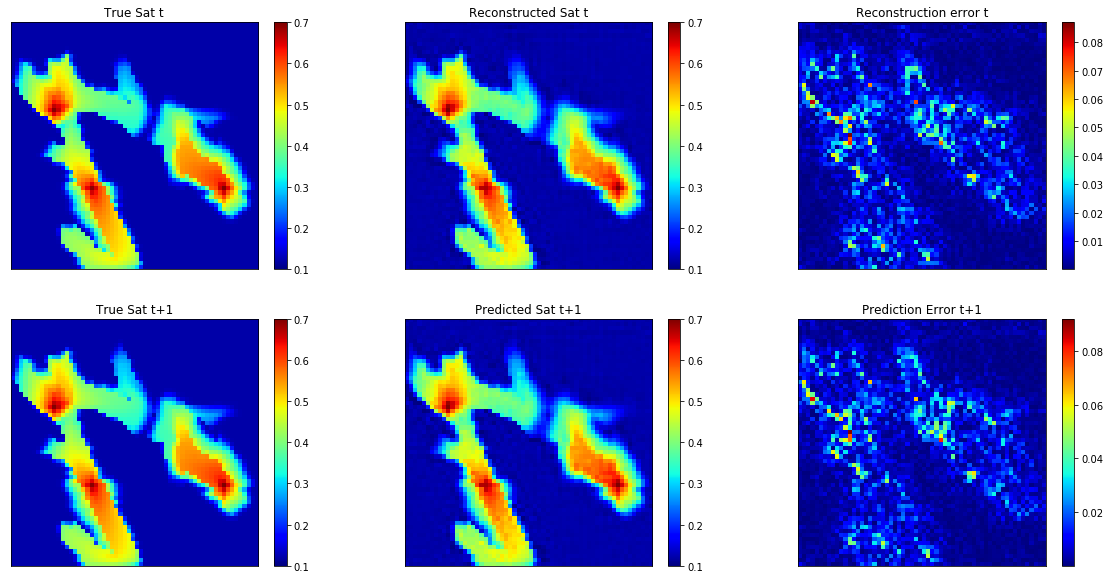

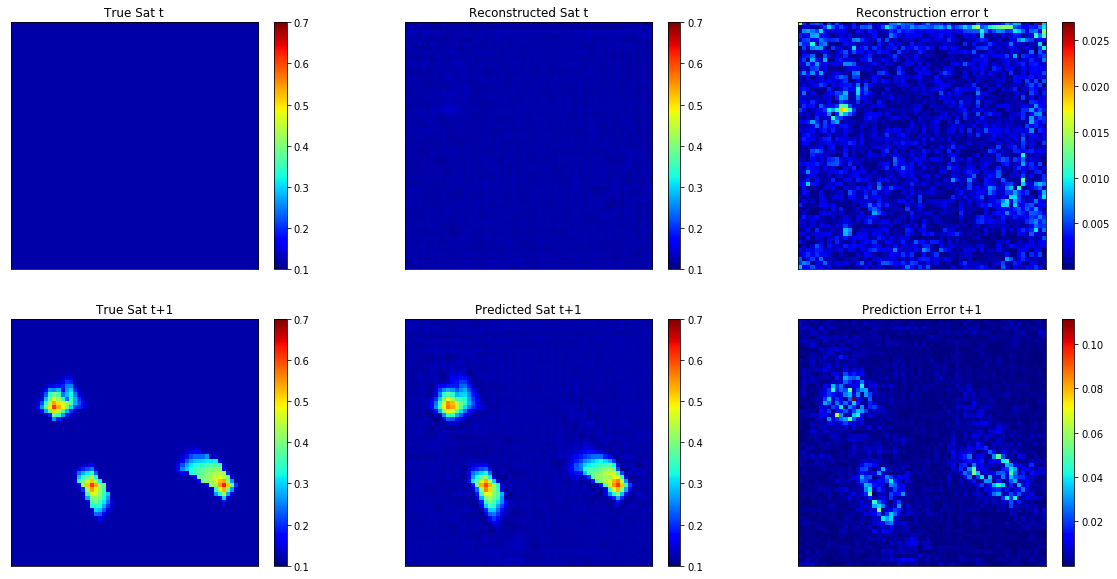

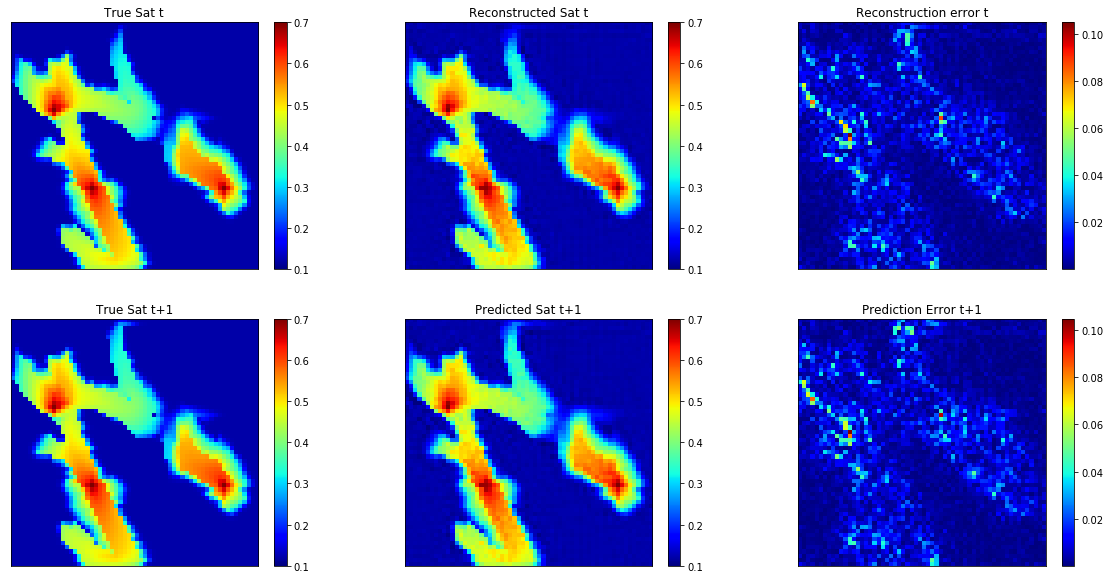

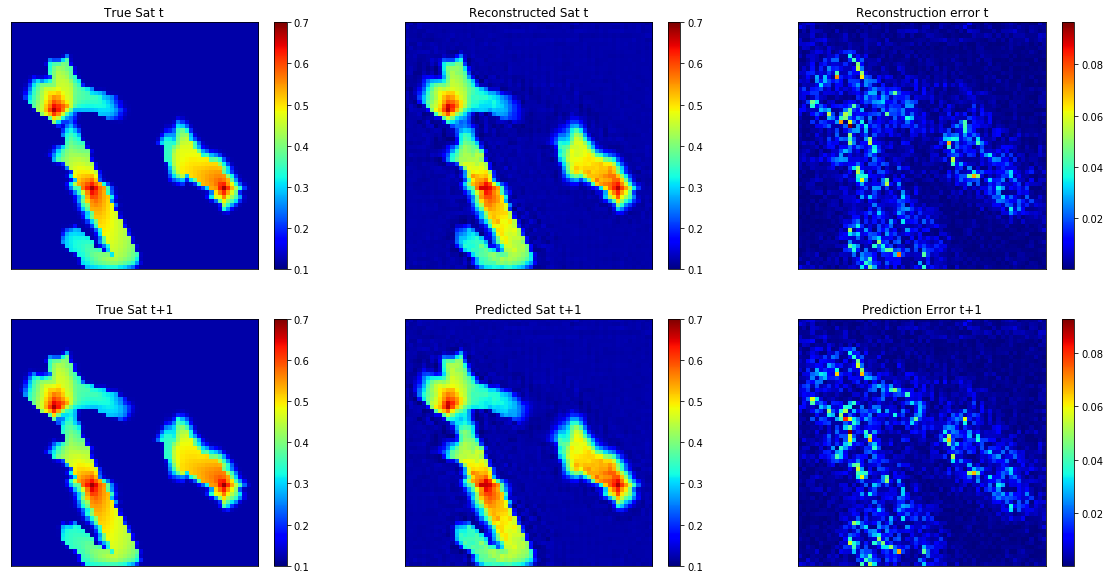

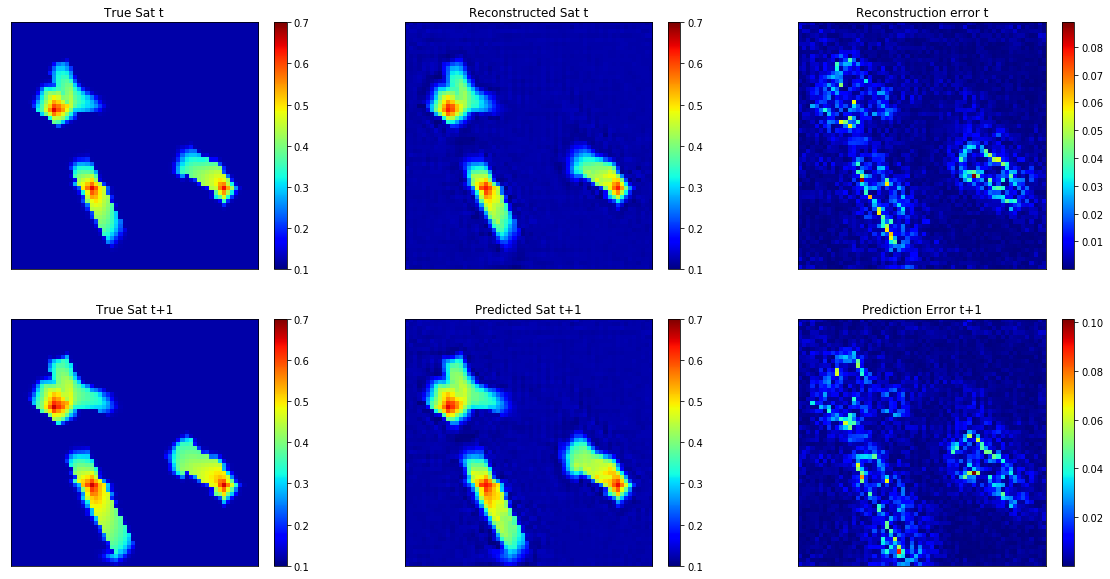

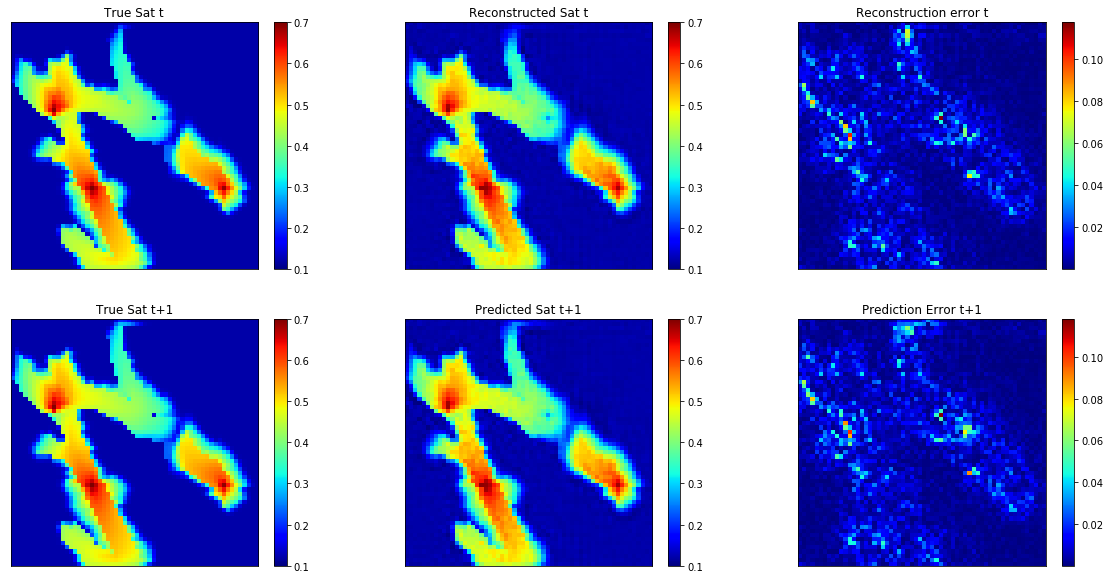

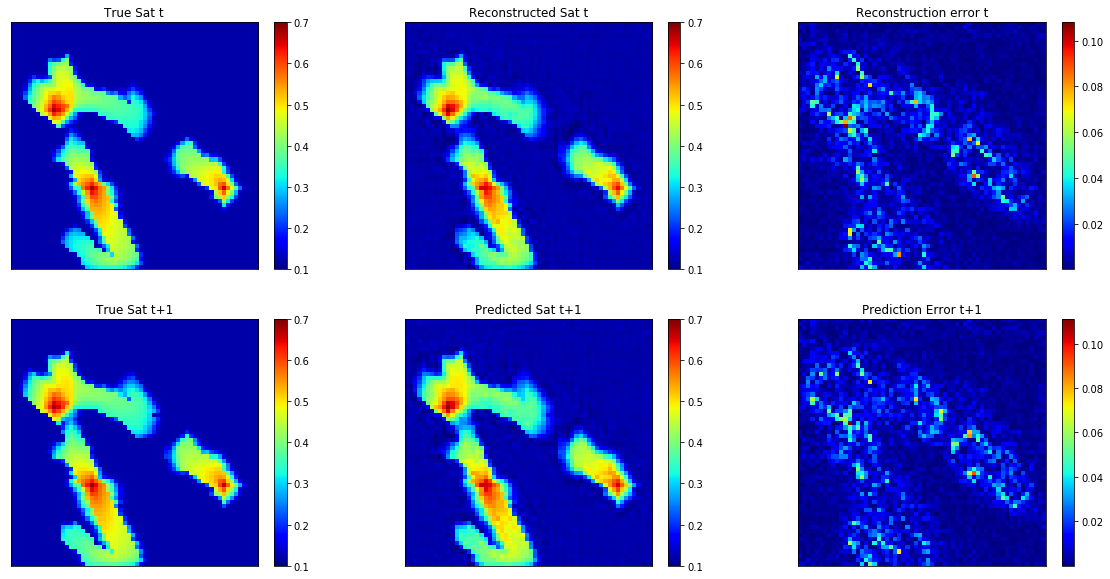

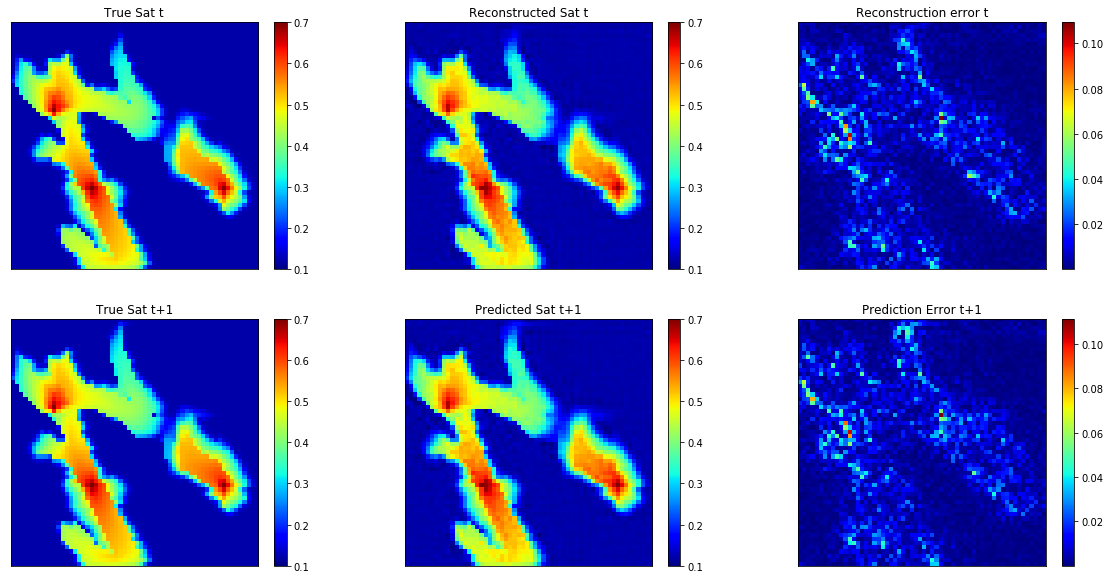

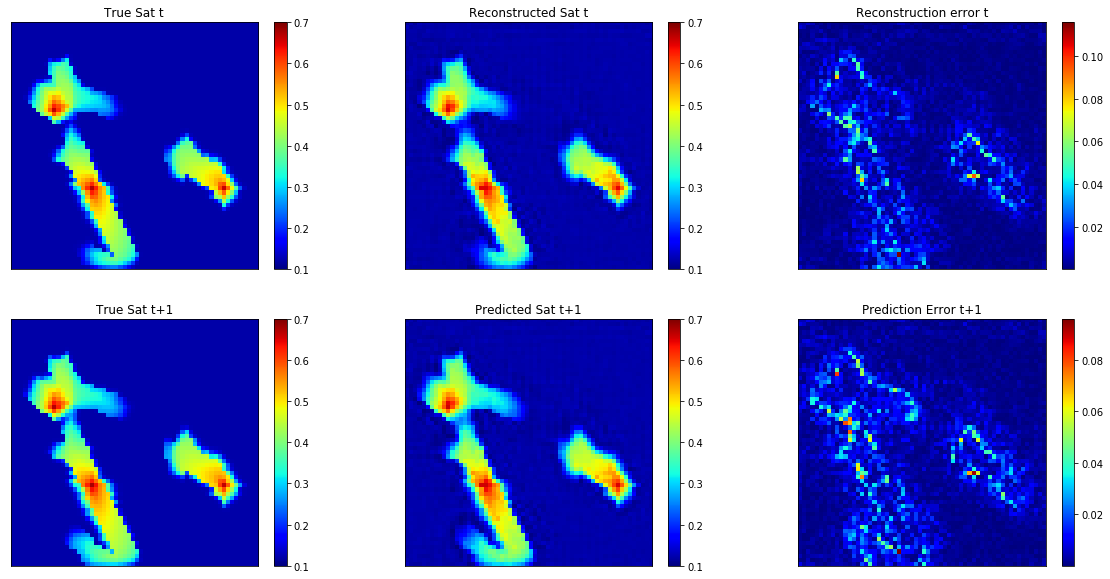

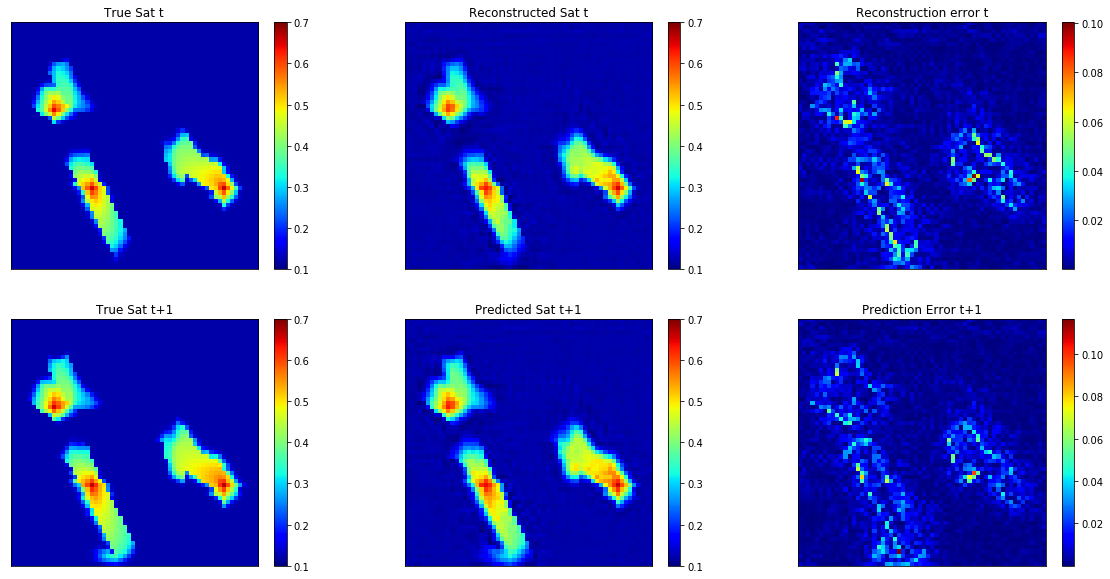

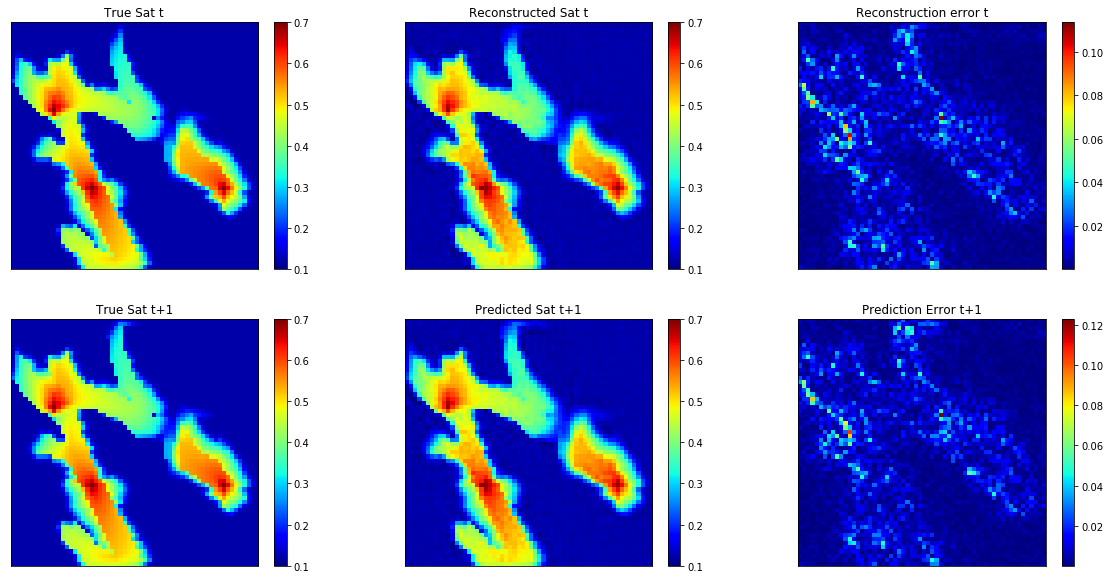

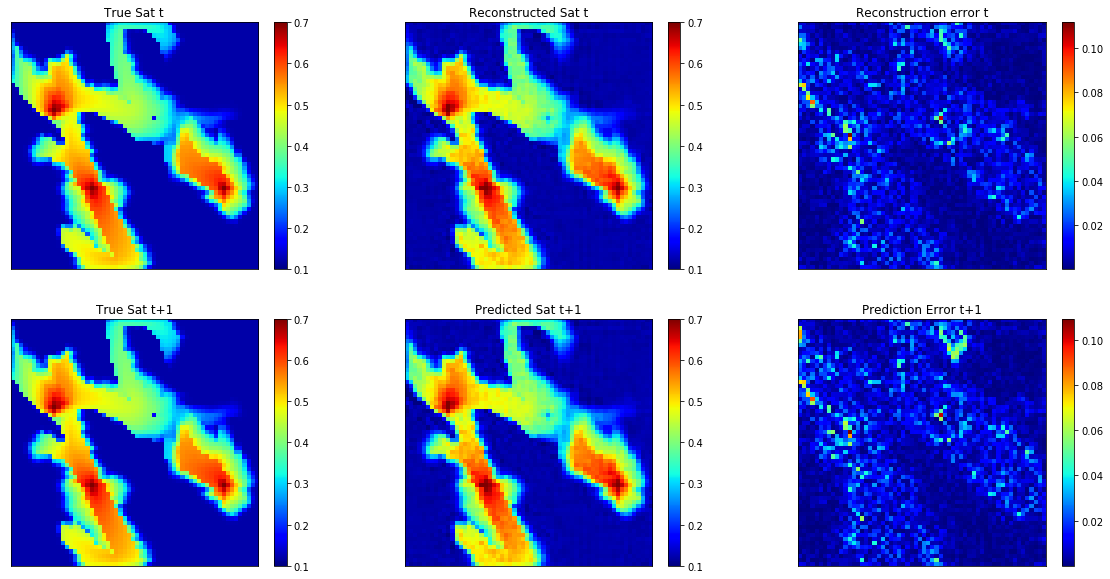

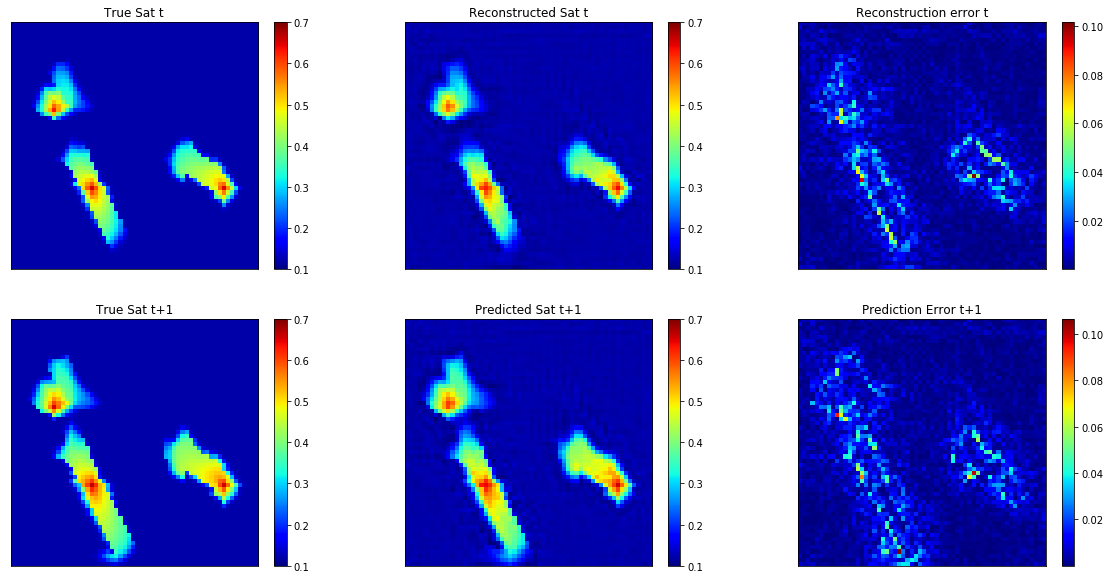

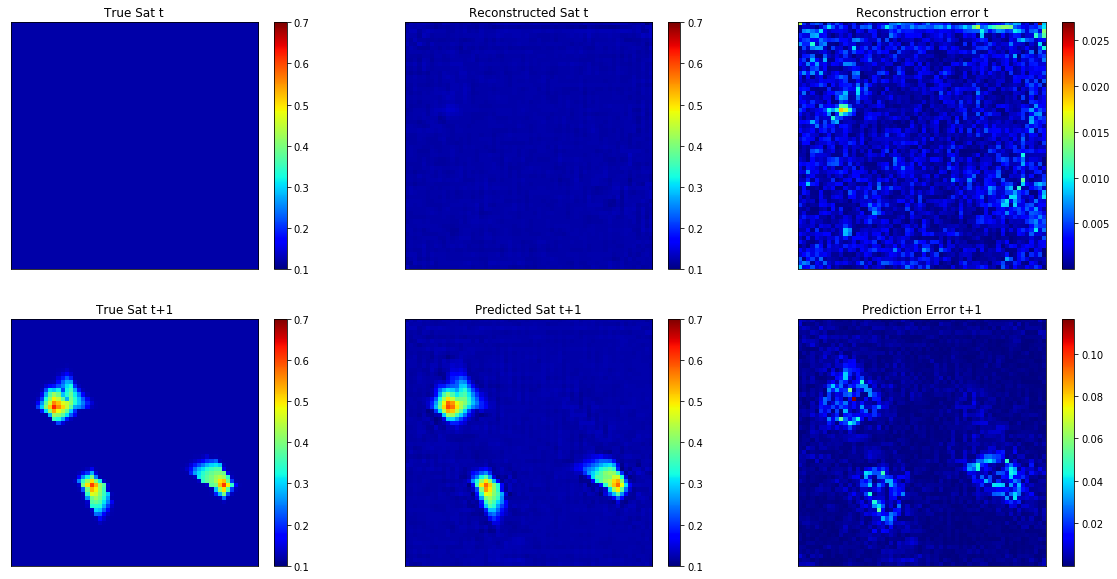

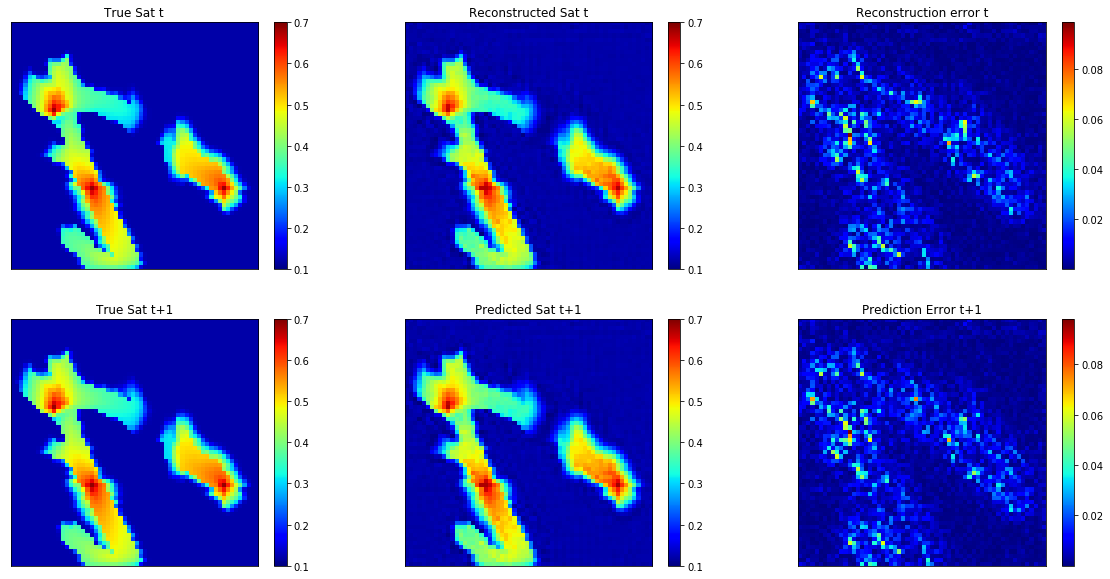

In [70]:
for k in range(num_eval):
    plt.figure(figsize=(20,10))
    plt.subplot(2, 3, 1)
    plt.imshow(state_t_eval_plot[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t')
    
    plt.subplot(2, 3, 2)
    plt.imshow(state_t_rec_plot[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstructed Sat t')
    
    plt.subplot(2, 3, 3)
    plt.imshow(np.fabs(state_t_rec_plot[k, :, :, 0] - state_t_eval_plot[k, :, :, 0]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstruction error t')
    
    plt.subplot(2, 3, 4)
    plt.imshow(state_t1_eval_plot[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Sat t+1')
    
    plt.subplot(2, 3, 5)
    plt.imshow(state_t1_pred_plot[k, :, :, 0])
    plt.clim([0.1, 0.7])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Sat t+1')
    
    plt.subplot(2, 3, 6)
    plt.imshow(np.fabs(state_t1_pred_plot[k, :, :, 0] - state_t1_eval_plot[k, :, :, 0]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction Error t+1')
plt.show()

In [71]:
# sat_threshold = 0.105

# sat_bin = np.where(state_t_eval[:,:,:,0]> sat_threshold, 1, 0)
# sat_t1_bin = np.where(state_t1_eval[:,:,:,0]> sat_threshold, 1, 0)

# sat_rec_bin = np.where(state_t_rec[:,:,:,0]> sat_threshold, 1, 0)
# sat_pred_bin = np.where(state_t1_pred[:,:,:,0]> sat_threshold, 1, 0)

In [72]:
# print(sat_bin.shape)

In [73]:
# for k in range(num_eval):
#     plt.figure(figsize=(20,10))
#     plt.subplot(2, 3, 1)
#     plt.imshow(sat_bin[k, :, :])
#     plt.clim([0, 1])
#     plt.colorbar(fraction=0.046)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title('True Sat t')
    
#     plt.subplot(2, 3, 2)
#     plt.imshow(sat_rec_bin[k, :, :])
#     plt.clim([0, 1])
#     plt.colorbar(fraction=0.046)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title('Reconstructed Sat t')
    
#     plt.subplot(2, 3, 3)
#     plt.imshow(np.fabs(sat_bin[k, :, :] - sat_rec_bin[k, :, :]))
#     plt.colorbar(fraction=0.046)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title('Reconstruction error t')
    
#     plt.subplot(2, 3, 4)
#     plt.imshow(sat_t1_bin[k, :, :])
#     plt.clim([0, 1])
#     plt.colorbar(fraction=0.046)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title('True Sat t+1')
    
#     plt.subplot(2, 3, 5)
#     plt.imshow(sat_pred_bin[k, :, :])
#     plt.clim([0, 1])
#     plt.colorbar(fraction=0.046)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title('Predicted Sat t+1')
    
#     plt.subplot(2, 3, 6)
#     plt.imshow(np.fabs(sat_pred_bin[k, :, :] - sat_t1_bin[k, :, :]))
#     plt.colorbar(fraction=0.046)
#     plt.xticks([])
#     plt.yticks([])
#     plt.title('Prediction Error t+1')
# plt.show()

In [74]:
p_max = 425
p_min = 250
p_diff = p_max - p_min

state_t_eval_plot = state_t_eval * p_diff + p_min
state_t_rec_plot = state_t_rec * p_diff + p_min
state_t1_eval_plot = state_t1_eval * p_diff + p_min
state_t1_pred_plot = state_t1_pred * p_diff + p_min

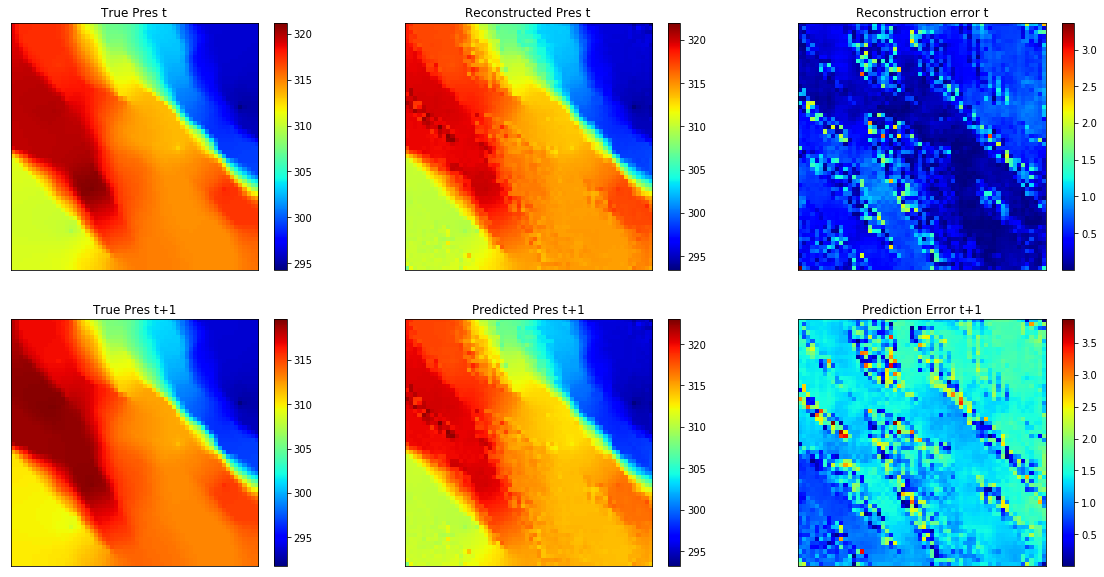

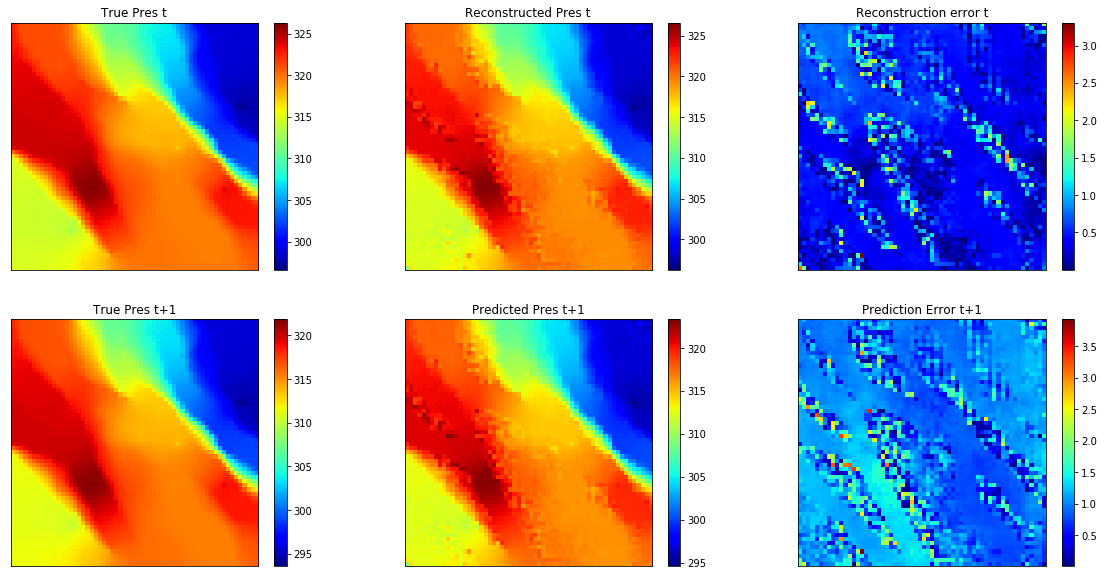

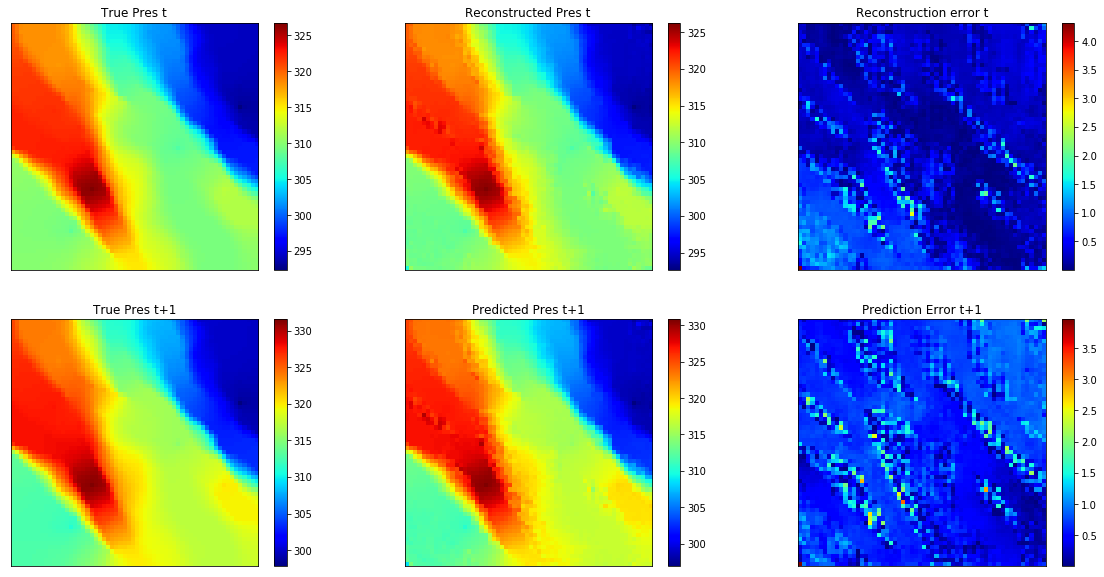

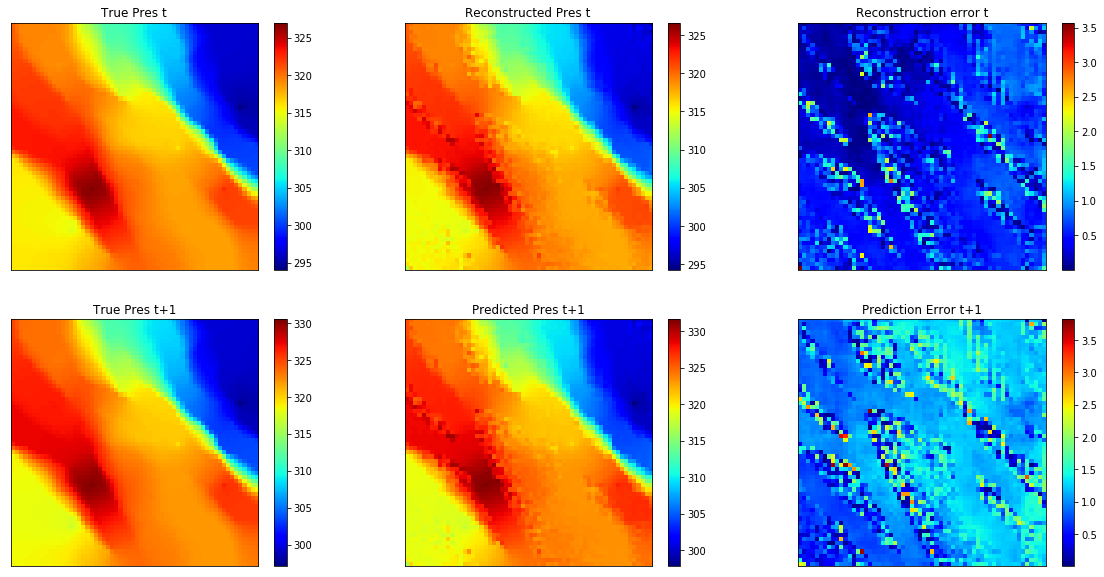

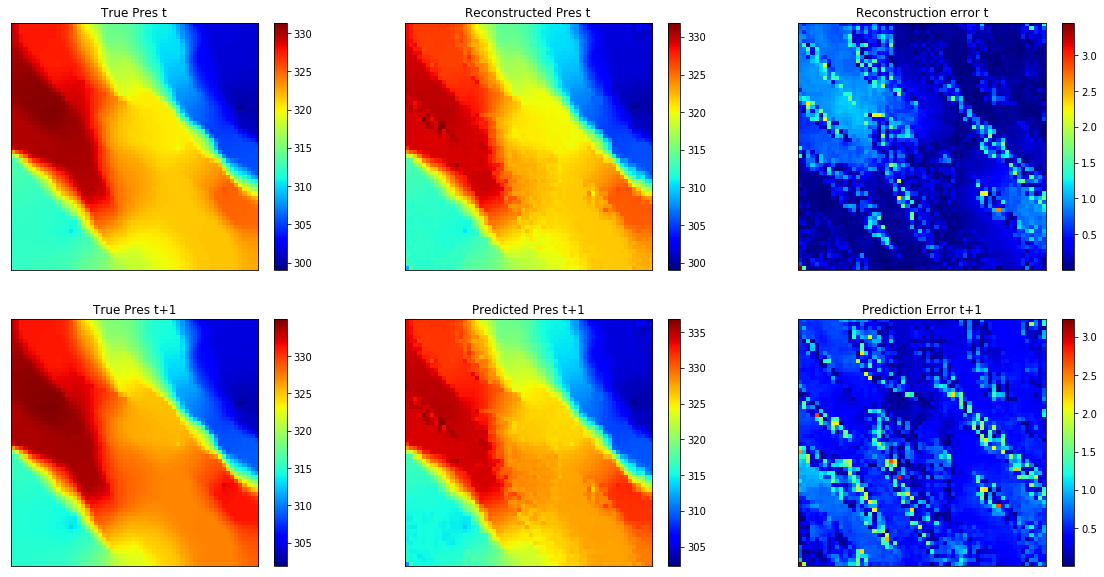

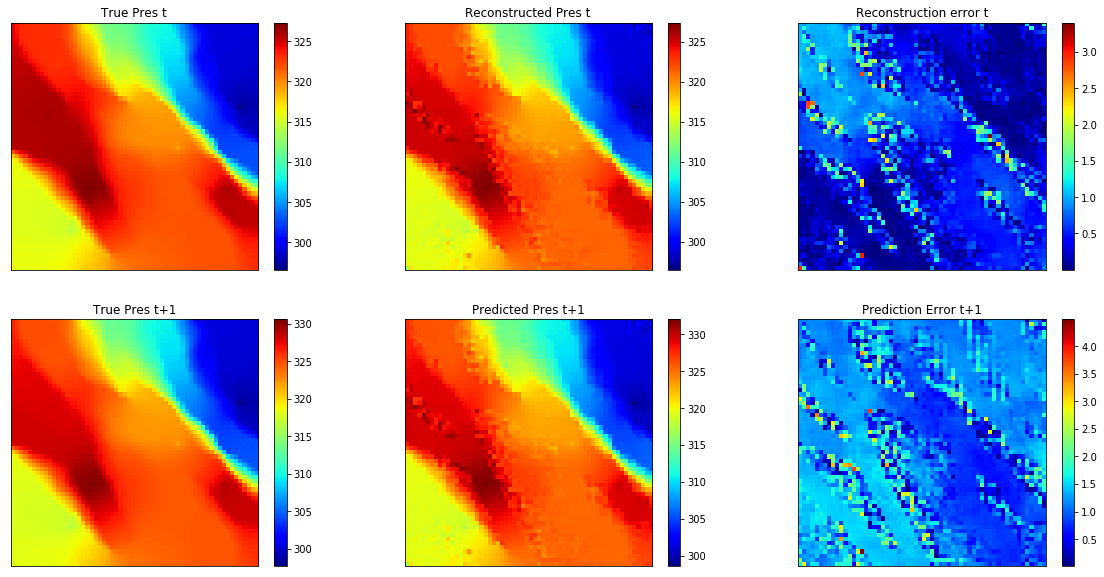

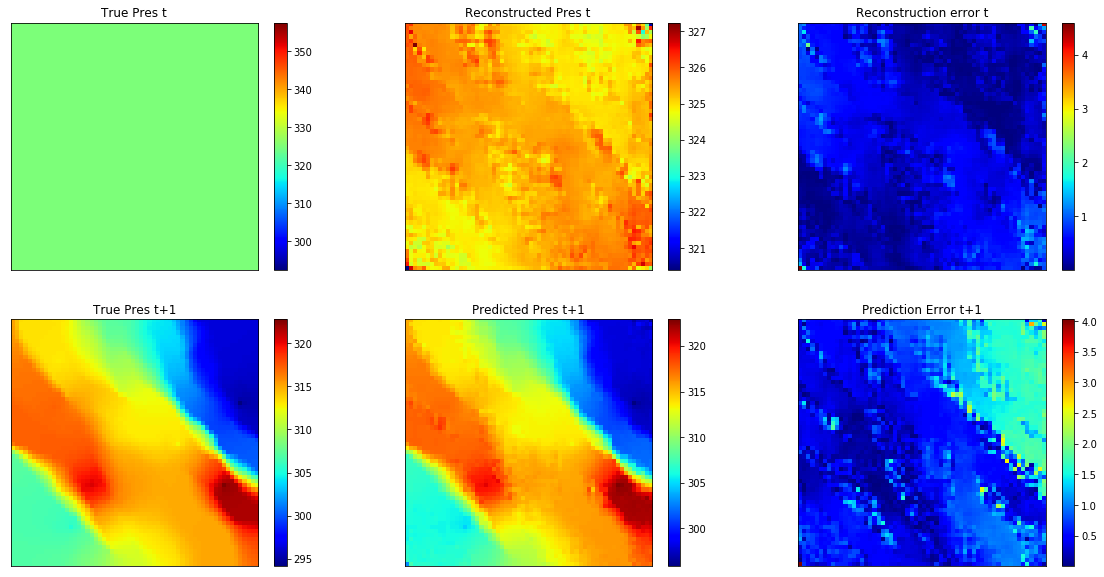

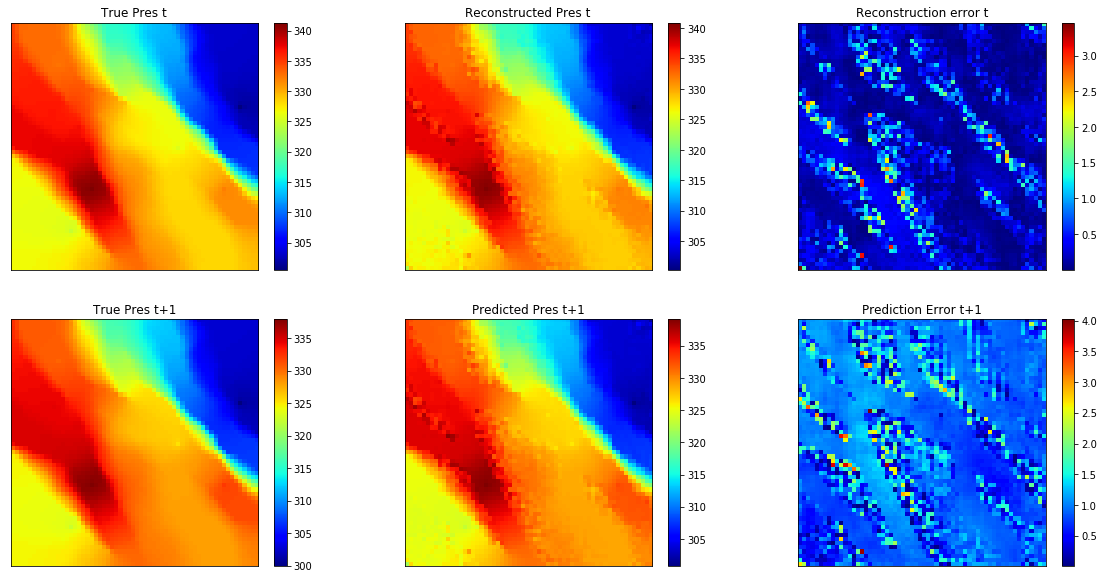

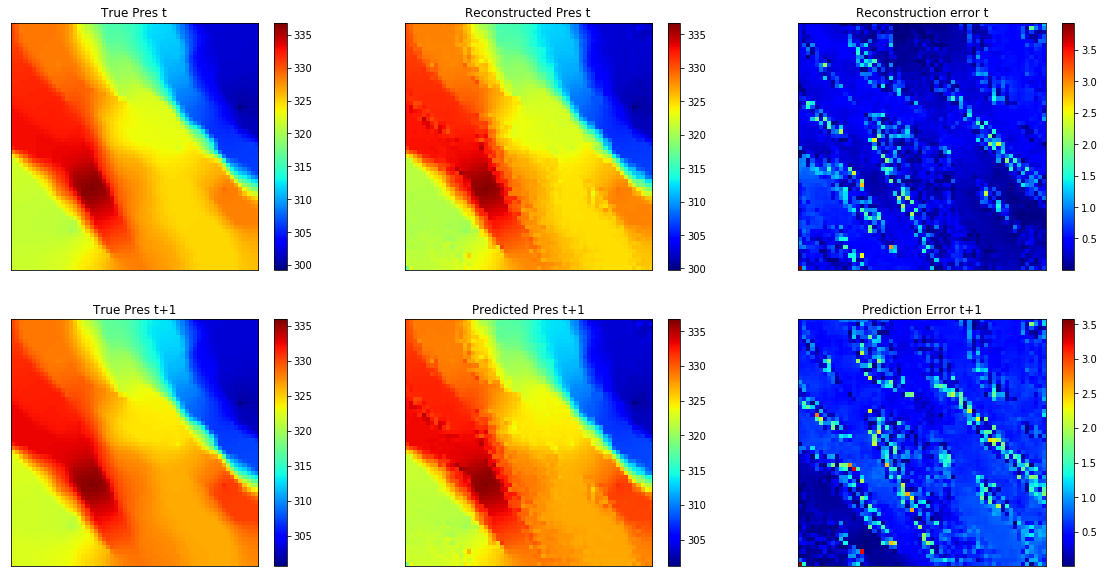

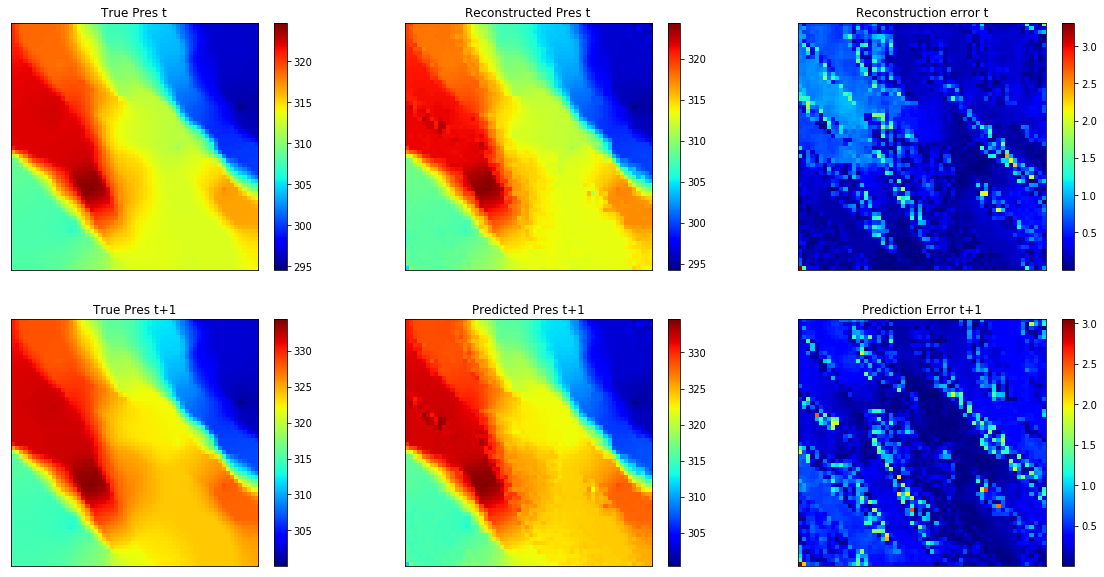

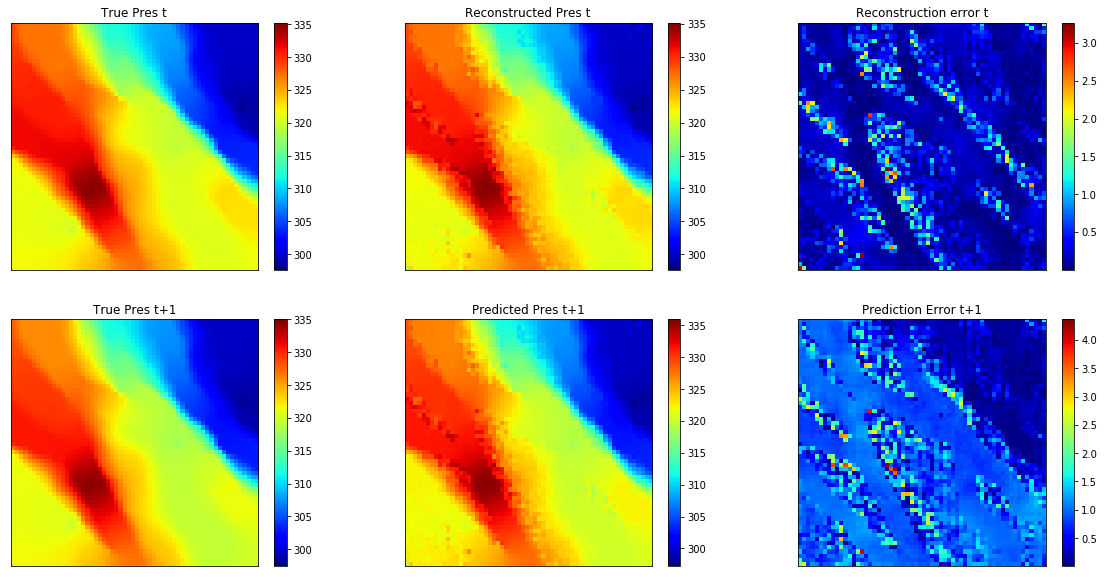

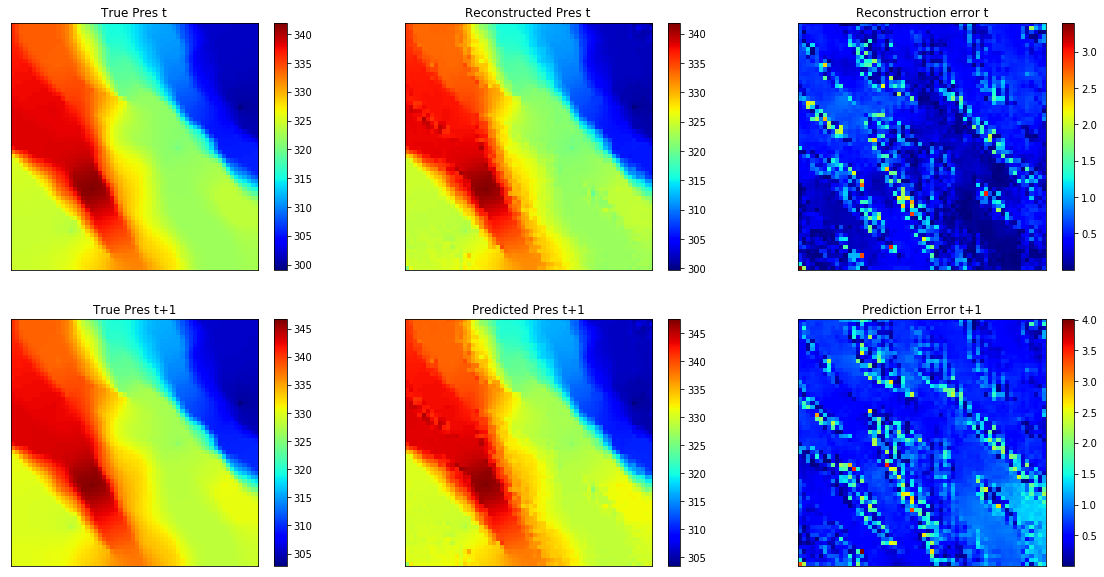

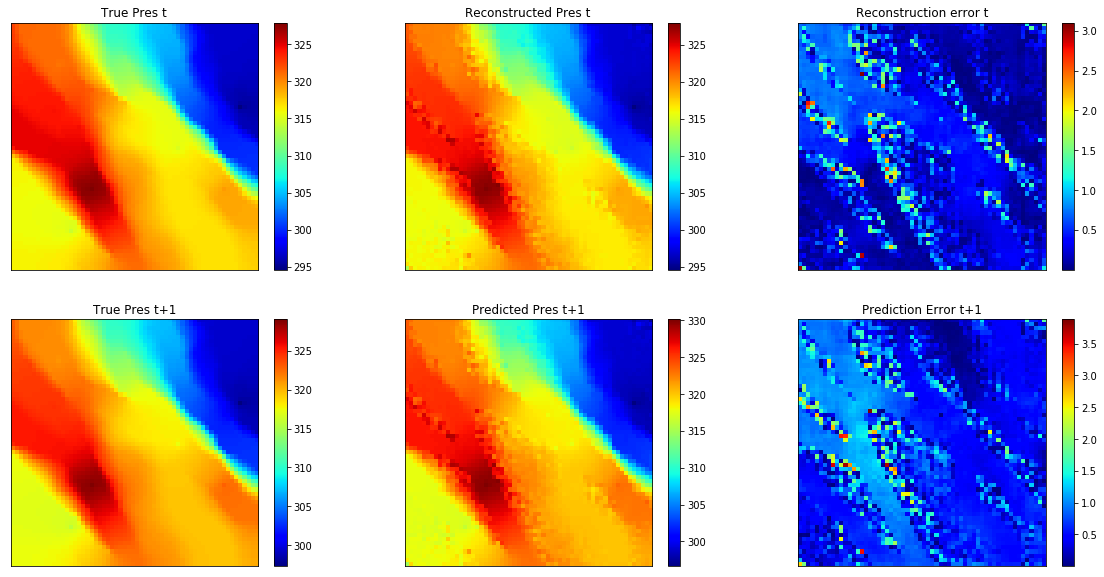

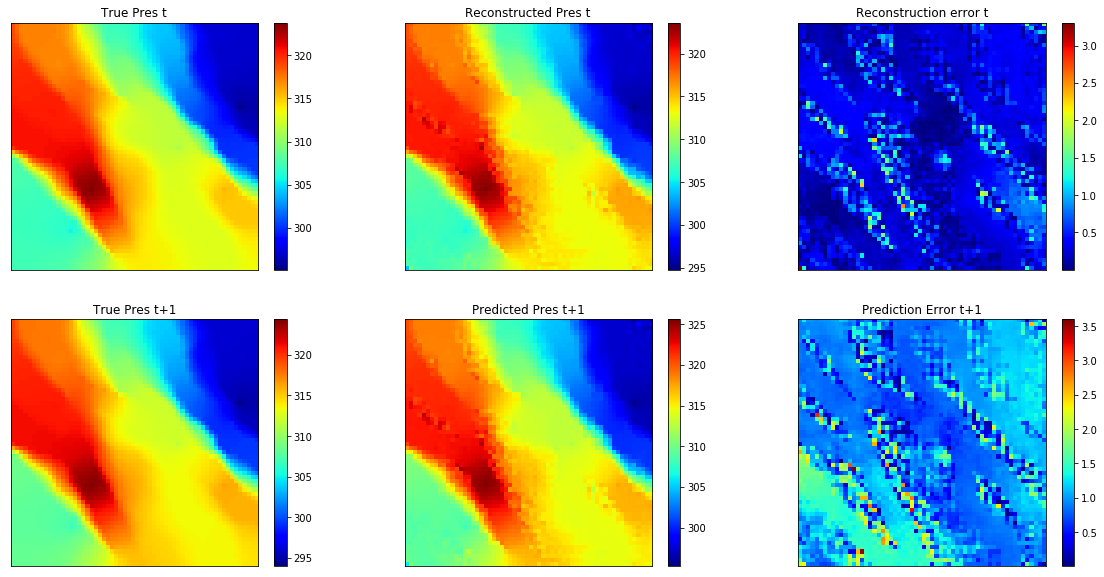

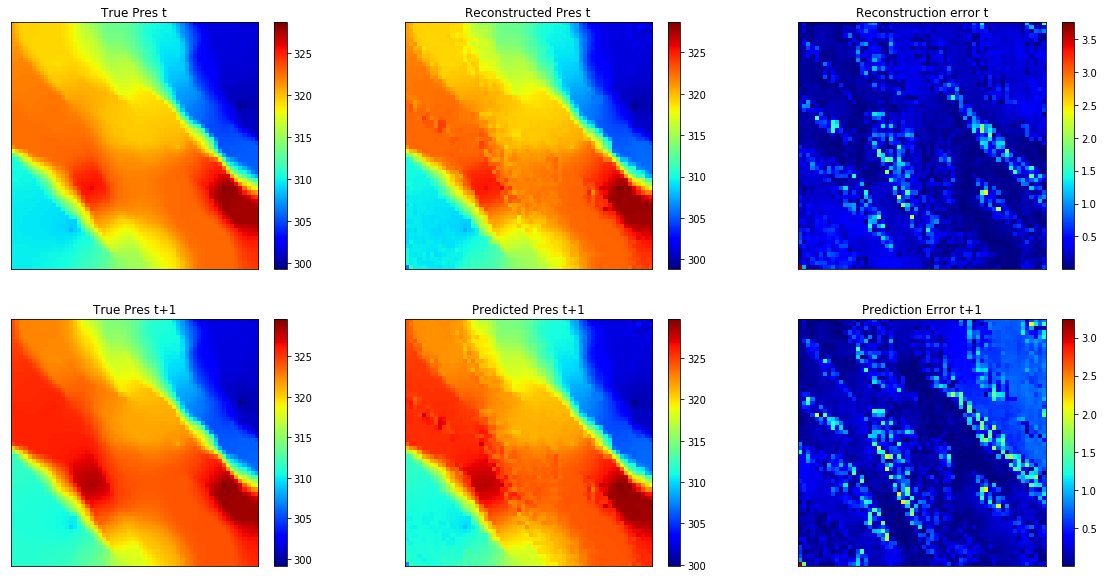

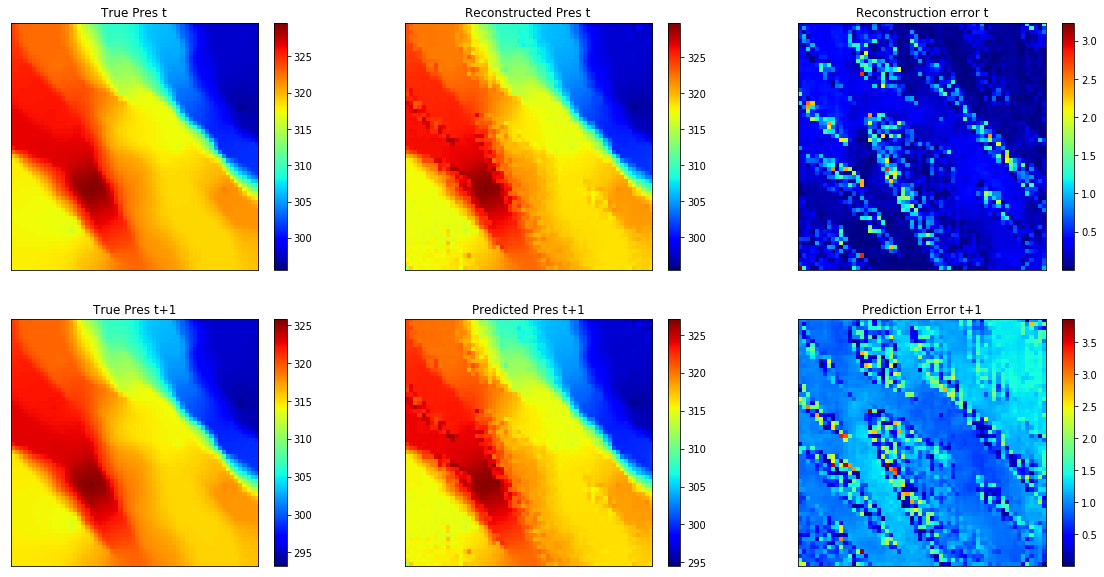

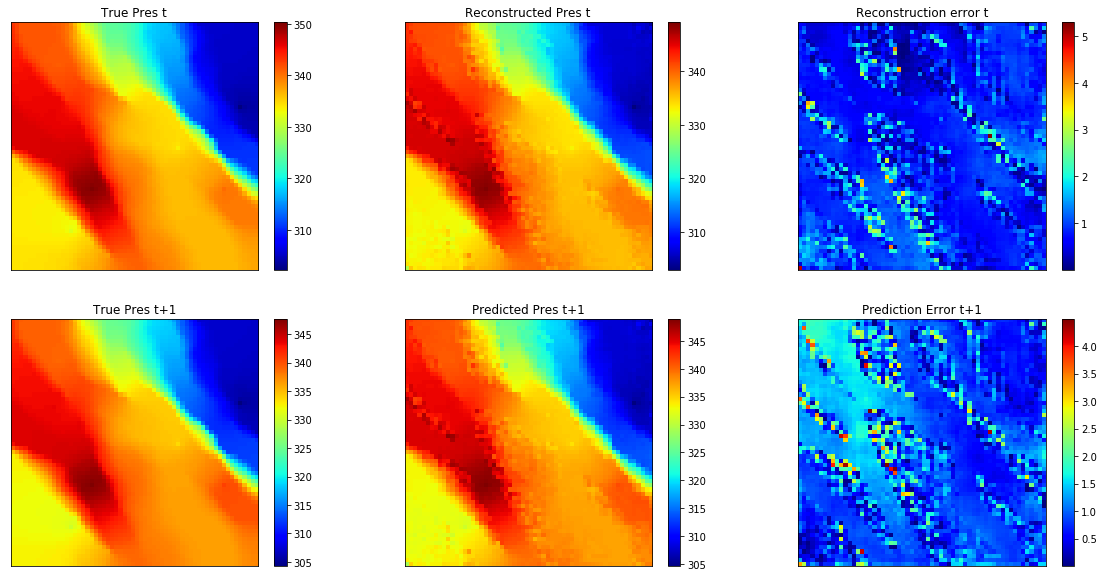

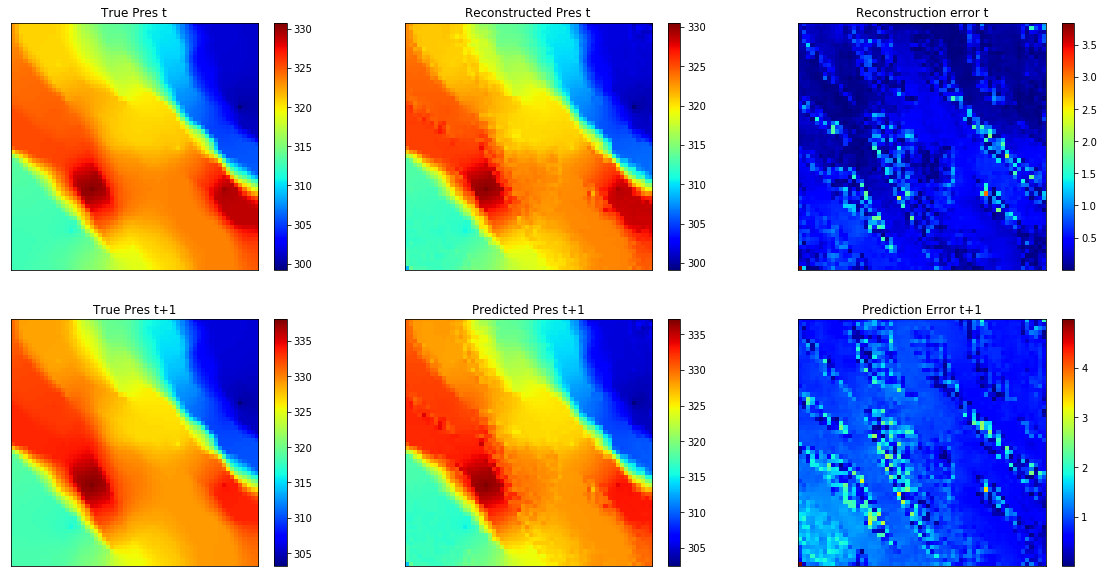

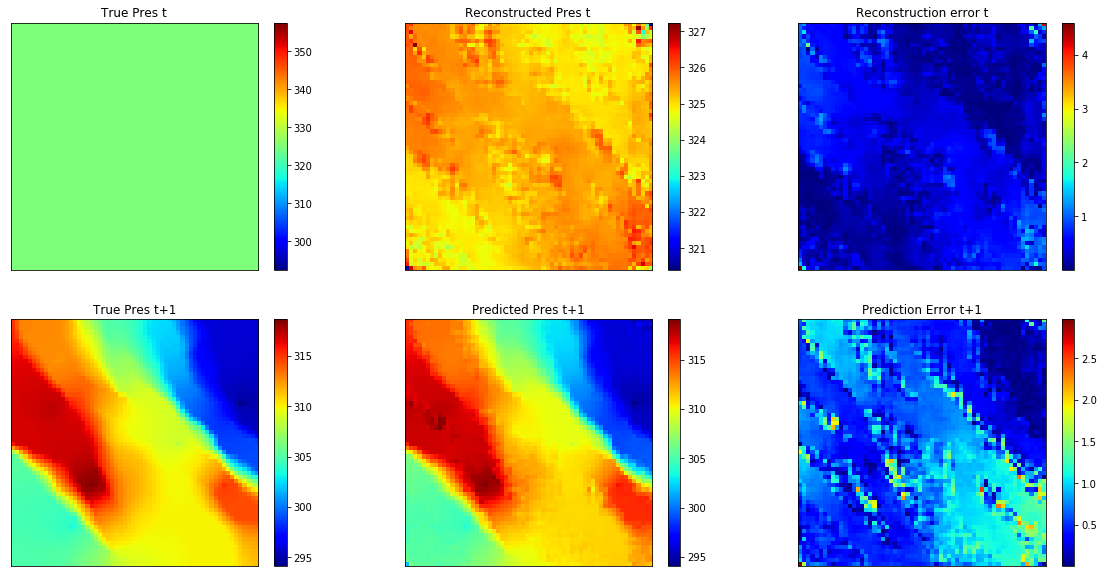

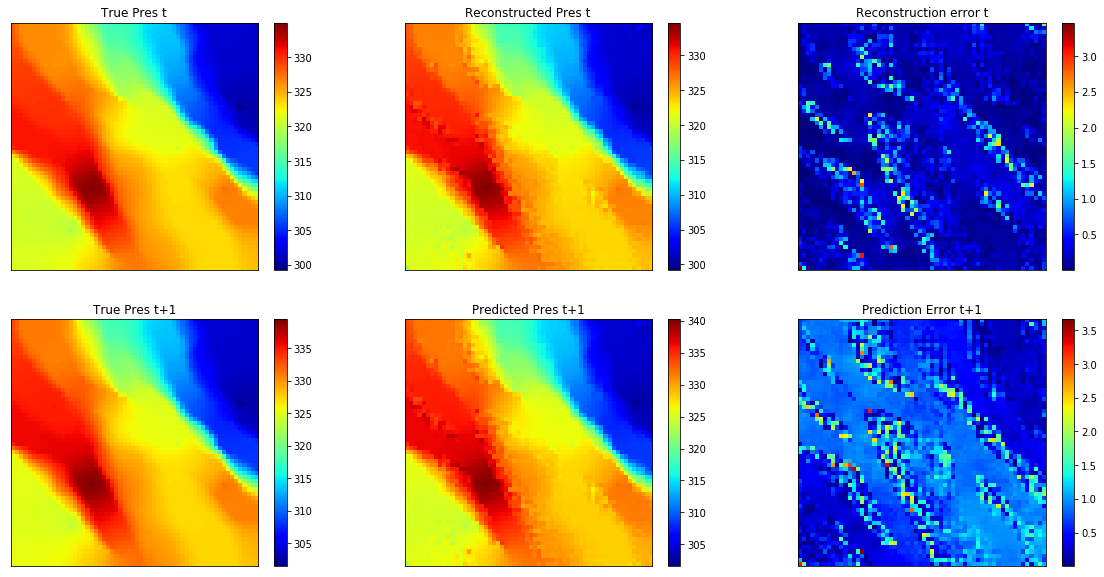

In [75]:
for k in range(num_eval):
    plt.figure(figsize=(20,10))
    plt.subplot(2, 3, 1)
    plt.imshow(state_t_eval_plot[k, :, :, 1])
#     plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Pres t')
    
    plt.subplot(2, 3, 2)
    plt.imshow(state_t_rec_plot[k, :, :, 1])
#     plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstructed Pres t')
    
    plt.subplot(2, 3, 3)
    plt.imshow(np.fabs(state_t_rec_plot[k, :, :, 1] - state_t_eval_plot[k, :, :, 1]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Reconstruction error t')
    
    plt.subplot(2, 3, 4)
    plt.imshow(state_t1_eval_plot[k, :, :, 1])
#     plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('True Pres t+1')
    
    plt.subplot(2, 3, 5)
    plt.imshow(state_t1_pred_plot[k, :, :, 1])
#     plt.clim([4150, 4600])
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Predicted Pres t+1')
    
    plt.subplot(2, 3, 6)
    plt.imshow(np.fabs(state_t1_pred_plot[k, :, :, 1] - state_t1_eval_plot[k, :, :, 1]))
    plt.colorbar(fraction=0.046)
    plt.xticks([])
    plt.yticks([])
    plt.title('Prediction Error t+1')
plt.show()

## Sequential prediction

In [76]:
hf_r = h5py.File(data_dir + state_data, 'r')
sat = np.array(hf_r.get('sat'))
pres = np.array(hf_r.get('pres'))
hf_r.close()

In [77]:
hf_r = h5py.File(data_dir + ctrl_data, 'r')
bhp0 = np.array(hf_r.get('bhp'))
rate0 = np.array(hf_r.get('rate'))
hf_r.close()
# bhp -= 0.45

In [78]:
bhp = np.concatenate((bhp0,rate0),axis=1)
print(bhp.shape)

(400, 140)


In [79]:
sat = sat.T.reshape((400, 201, 3600))
pres = pres.T.reshape((400, 201, 3600))

In [80]:
test_case0 = np.zeros((25,4))
a = np.array(range(75,400,100))[np.newaxis,:]
b = np.array(range(25))[:,np.newaxis]
print(a.shape)
print(b.shape)
test_case = (test_case0 + a + b).T.reshape(100)
test_case = np.array(test_case).astype(int)

# test_case = np.array(test_case)
print(test_case.shape)

(1, 4)
(25, 1)
(100,)


In [81]:
# ind_case = np.array(range(0, 100, 25)) + 10

ind_case = np.array([10, 25, 77, 97])
print(ind_case)

[10 25 77 97]


In [82]:
num_case = test_case.shape[0] # 4
num_tstep = 20
sat_pred = np.zeros((num_case, num_tstep, 60, 60, 1))
pres_pred = np.zeros((num_case, num_tstep, 60, 60, 1))

In [83]:
# t_steps = list(np.arange(0,100,10))
t_steps = np.arange(0,200,200//num_tstep)
print(t_steps)
# num_tstep = len(t_steps)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]


In [84]:
dt = 10
t_steps1 = (t_steps + dt).astype(int)
print(t_steps1)

[ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]


In [85]:
indt_del = t_steps1 - t_steps
indt_del = indt_del / max(indt_del)
print(indt_del.shape)

(20,)


In [86]:
tmp = np.array(range(num_tstep)) - 1
tmp1 = np.array(range(num_tstep))
tmp[0] = 0

print(tmp)
print(tmp1)
print(bhp.shape)

[ 0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
(400, 140)


In [87]:
num_prod = 4
num_inj = 3
num_well = num_prod + num_inj

num_all_case = 400
num_ctrl = 20


In [88]:
print(num_ctrl)
print(num_tstep)

20
20


In [89]:
bhp_b0 = bhp.reshape(num_all_case, num_well, num_ctrl)
bhp_b1 = np.repeat(bhp_b0[..., np.newaxis], num_tstep // num_ctrl, axis=3)
assert num_tstep // num_ctrl * num_ctrl == num_tstep, "no exaxt division num_step = %d, num_ctrl=%d"%(num_tstep, num_ctrl)

print(bhp_b1.shape)
bhp_b2 = bhp_b1.reshape(num_all_case, num_well, num_tstep)
print(bhp_b2.shape)

(400, 7, 20, 1)
(400, 7, 20)


In [90]:
bhp_tt = bhp_b2[:,:, tmp]
bhp_tt1 = bhp_b2[:,:, tmp1]
print(bhp_tt.shape)
print(bhp_tt1.shape)

bhp_tt0 = np.concatenate((bhp_tt, bhp_tt1), axis=1)
bhp_t = np.swapaxes(bhp_tt0,1,2)
print(bhp_t.shape)
print(bhp[0,:20])
print(bhp_t[0,:,9])

(400, 7, 20)
(400, 7, 20)
(400, 20, 14)
[0.13563532 0.11714268 0.11925315 0.12525658 0.12789043 0.13145832
 0.11946358 0.13208731 0.129524   0.13480344 0.13965102 0.12298142
 0.1249027  0.14177363 0.12736432 0.13044347 0.14159801 0.13043148
 0.1308215  0.1423218 ]
[0.13712794 0.12825785 0.13576085 0.1173268  0.11489406 0.13690317
 0.11587831 0.13754447 0.13141211 0.12030358 0.13660337 0.12031934
 0.13653711 0.11652366 0.13371429 0.13158443 0.13278957 0.11857339
 0.13304365 0.11635248]


In [91]:
bhp_seq = bhp_t[test_case, :, :]
print(bhp_seq.shape)

(100, 20, 14)


In [92]:
sat_t_seq = sat[test_case, 0, :].reshape((num_case, 60, 60, 1)) # 4 here is the 4th timestep, t = 8
pres_t_seq = pres[test_case, 0, :].reshape((num_case, 60, 60, 1))
print(sat_t_seq.shape)
print(pres_t_seq.shape)
print("num_case:{}".format(num_case))

(100, 60, 60, 1)
(100, 60, 60, 1)
num_case:100


In [93]:
# plt.figure(figsize=(15,6))
# for k in range(len(ind_case)):
#     plt.subplot(2,4,k+1)
#     plt.imshow(sat_t_seq[ind_case[k], :, :, 0])
#     plt.colorbar(fraction=0.046)
    
#     plt.subplot(2,4,k+5)
#     plt.imshow(pres_t_seq[ind_case[k], :, :, 0])
#     plt.colorbar(fraction=0.046)
# plt.show()

In [94]:
print(sat_t_seq.shape)
print(sat_pred.shape)
print(pres_t_seq.shape)
print(pres_pred.shape)
print(bhp_seq.shape)

(100, 60, 60, 1)
(100, 20, 60, 60, 1)
(100, 60, 60, 1)
(100, 20, 60, 60, 1)
(100, 20, 14)


In [95]:
state_t_seq = np.concatenate((sat_t_seq, pres_t_seq),axis=3)
state_pred = np.concatenate((sat_pred, pres_pred),axis=4)
print(state_t_seq.shape)
print(state_pred.shape)

(100, 60, 60, 2)
(100, 20, 60, 60, 2)


In [96]:
# plt.figure(figsize=(15,3))
# for k in range(len(ind_case)):
#     plt.subplot(1,4,k+1)
#     plt.imshow(state_t_seq[ind_case[k], :, :, 0])
#     plt.colorbar(fraction=0.046)
# plt.show()

In [97]:
for i_tstep in range(num_tstep):
    state_pred[:, i_tstep, ...] = state_t_seq.copy()
    dt_seq = np.ones((num_case,1)) * indt_del[i_tstep]
    [_, state_t1_seq] = e2c_model.predict([state_t_seq, bhp_seq[:,i_tstep,:], dt_seq])
    state_t_seq = state_t1_seq.copy()

In [98]:
print(sat.shape)
print(pres.shape)
# print(state.shape)
print(state_pred.shape)

(400, 201, 3600)
(400, 201, 3600)
(100, 20, 60, 60, 2)


In [99]:
# sat_seq_true = sat[test_case[ind_case], ...]
sat_seq_true = sat[test_case, ...]
sat_seq_true = sat_seq_true[:, list(np.arange(0,200,10)), :]
print(sat_seq_true.shape)

# pres_seq_true = pres[test_case[ind_case], ...]
pres_seq_true = pres[test_case, ...]
pres_seq_true = pres_seq_true[:, list(np.arange(0,200,10)), :]
print(pres_seq_true.shape)
state_seq_true = np.zeros((len(test_case),20,3600,2))
state_seq_true[:,:,:,0] = sat_seq_true
state_seq_true[:,:,:,1] = pres_seq_true
print(state_seq_true.shape)

(100, 20, 3600)
(100, 20, 3600)
(100, 20, 3600, 2)


In [100]:
sat_pred_plot = state_pred[:, :, :, :, 0] * s_diff + s_min
state_pred[:, :, :, :, 0] = state_pred[:, :, :, :, 0] * s_diff + s_min

Case num: 10


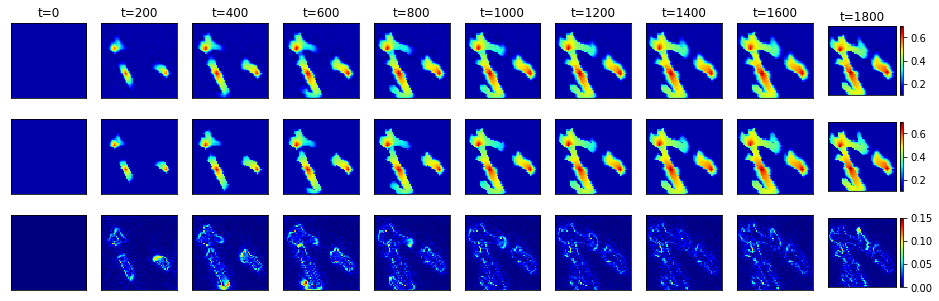

Case num: 25


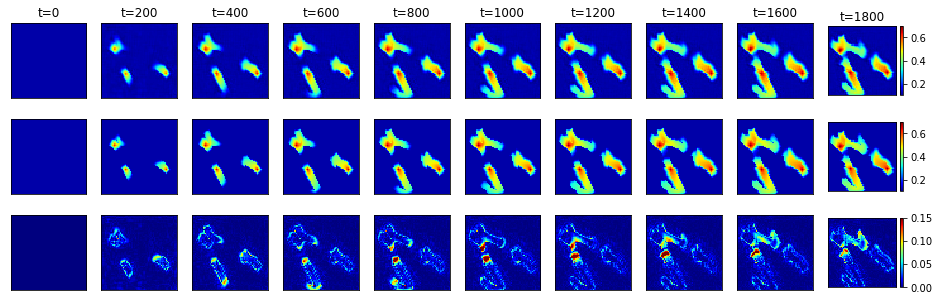

Case num: 77


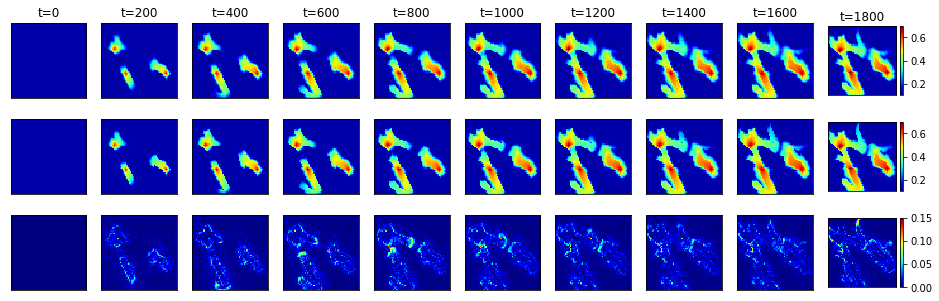

Case num: 97


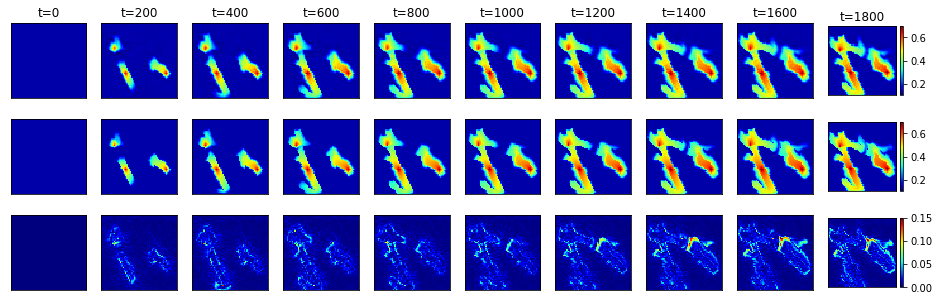

In [101]:
divide = 2
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//divide):
        plt.subplot(3, num_tstep//divide, i_tstep+1)
        plt.imshow(sat_pred_plot[ind_case[k], i_tstep*divide, :,:])
        plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_seq_true[ind_case[k], i_tstep*divide, :, 0].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0.1, 0.7])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(np.fabs(state_seq_true[ind_case[k], i_tstep*divide, :, 0].reshape((60,60)) - sat_pred_plot[ind_case[k], i_tstep*divide, :,:]))
        plt.xticks([])
        plt.yticks([])
        plt.clim([0, 0.15])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

In [102]:
state_pred_plot = state_pred[:, :, :, :, 1] * p_diff + p_min
state_seq_true_plot = state_seq_true[:, :, :, 1] * p_diff + p_min
print(state_pred_plot.shape)
print(state_seq_true_plot.shape)

(100, 20, 60, 60)
(100, 20, 3600)


Case num: 10


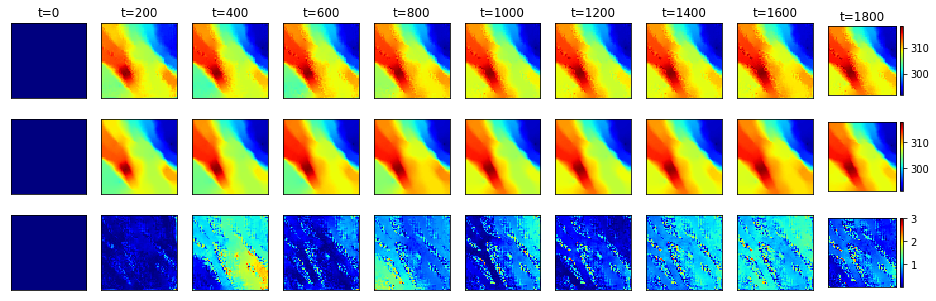

Case num: 25


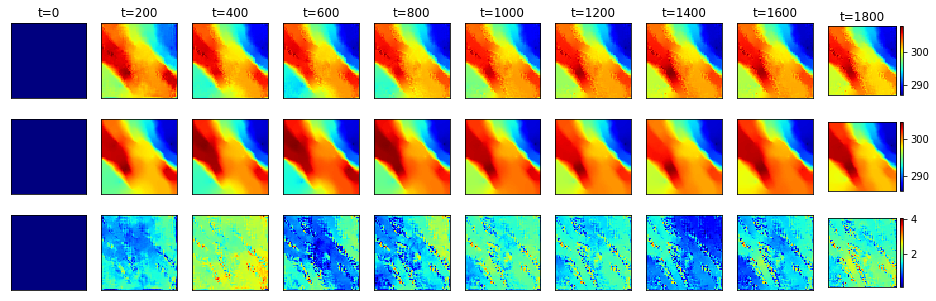

Case num: 77


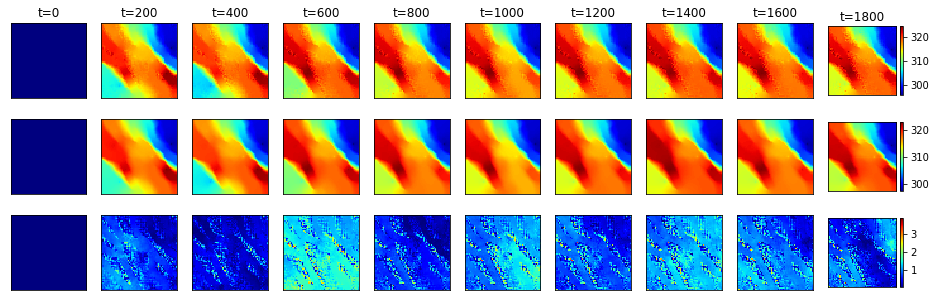

Case num: 97


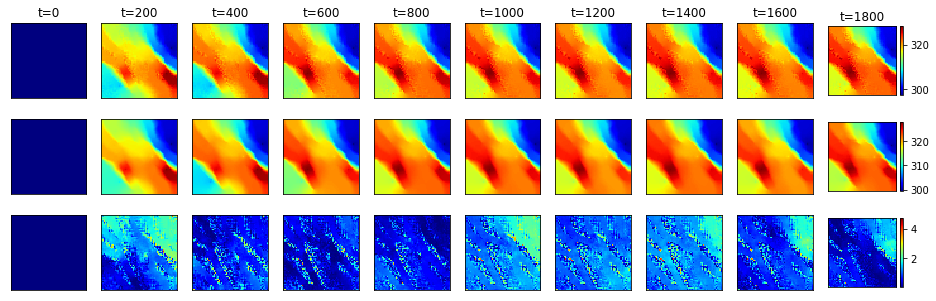

In [103]:
divide = 2
for k in range(4):
    print("Case num: %d"%ind_case[k])
    plt.figure(figsize=(16,5))
    for i_tstep in range(len(t_steps)//divide):
        plt.subplot(3, num_tstep//divide, i_tstep+1)
        plt.imshow(state_pred_plot[ind_case[k], i_tstep*divide, :, :])
        plt.title('t=%d'%(t_steps[i_tstep*divide]*dt))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 
            
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+num_tstep//divide)
        plt.imshow(state_seq_true_plot[ind_case[k], i_tstep*divide, :].reshape((60,60)))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([4150, 4650])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046)         
        
        plt.subplot(3, num_tstep//divide, i_tstep+1+2*num_tstep//divide)
        plt.imshow(np.fabs(state_seq_true_plot[ind_case[k], i_tstep*divide, :].reshape((60,60)) - state_pred_plot[ind_case[k], i_tstep*divide, :,:]))
        plt.xticks([])
        plt.yticks([])
#         plt.clim([0, 0.02])
        if i_tstep == 9:
            plt.colorbar(fraction=0.046) 

    plt.show()

In [104]:
print(state_seq_true.shape)
print(state_pred.shape)
print(bhp_seq.shape)

(100, 20, 3600, 2)
(100, 20, 60, 60, 2)
(100, 20, 14)


In [105]:
print(ind_case)

[10 25 77 97]


In [106]:
train_case0 = np.zeros((75,4))
a = np.array(range(0,400,100))[np.newaxis,:]
b = np.array(range(75))[:,np.newaxis]
print(a.shape)
print(b.shape)
train_case = (train_case0 + a + b).T.reshape(300)
train_case = np.array(train_case)
print(train_case)

(1, 4)
(75, 1)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74. 100. 101. 102. 103. 104. 105. 106. 107. 108.
 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122.
 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136.
 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150.
 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164.
 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 200. 201. 202. 203.
 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217.
 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231.
 232. 233. 234. 235. 236. 237. 238. 239. 240. 241. 242. 243. 2

In [107]:
print(sat.shape)
print(pres.shape)
sat_seq_train0 = sat[train_case.astype(int), :, :] 
pres_seq_train0 = pres[train_case.astype(int), :, :]
sat_seq_train = sat_seq_train0[:, np.arange(0,200,10), :]
pres_seq_train = pres_seq_train0[:, np.arange(0,200,10), :]
print(sat_seq_true.shape)
print(pres_seq_true.shape)

state_seq_train = np.zeros((300,20,3600,2))
state_seq_train[:,:,:,0] = sat_seq_train
state_seq_train[:,:,:,1] = pres_seq_train
print(state_seq_train.shape)

(400, 201, 3600)
(400, 201, 3600)
(100, 20, 3600)
(100, 20, 3600)
(300, 20, 3600, 2)


In [108]:
bhp_train = bhp[train_case.astype(int),:]
bhp_eval = bhp[test_case.astype(int),:]
print(state_seq_true.shape)
print(state_pred.shape)
print(state_seq_train.shape)
print(bhp_seq.shape)
print(bhp_train.shape)
print(bhp_eval.shape)


(100, 20, 3600, 2)
(100, 20, 60, 60, 2)
(300, 20, 3600, 2)
(100, 20, 14)
(300, 140)
(100, 140)


In [109]:
# output_dir = '/data3/Astro/lstm_rom/e2c_larry/data/9w_ms_bhp_rate_fix_wl/'
output_dir = '/data3/Astro/lstm_rom/e2c_larry/data/' + case_name + '/'

hf_w = h5py.File(output_dir + case_name + target_suffix + '_nt_%d_state_seq_pred_ctrl.mat'%(num_train), 'w')
hf_w.create_dataset('true_seq', data=state_seq_true)
hf_w.create_dataset('pred_seq', data=state_pred)
hf_w.create_dataset('train_seq', data=state_seq_train)
hf_w.create_dataset('ctrl_seq', data=bhp_seq)
hf_w.create_dataset('train_ctrl', data=bhp_train)
hf_w.create_dataset('eval_ctrl', data=bhp_eval)
hf_w.close()

In [110]:
print(num_train)

6000
